# Setup

In [4]:
import pandas as pd
import numpy as np
import os

# To serialise models
from sklearn.externals import joblib

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import seaborn as sns
sns.set()

# to make this notebook's output stable across runs
np.random.seed(42)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if not os.path.isdir(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


PROCESSED_PATH = os.path.join(PROJECT_ROOT_DIR, "processed")
def save_processed(df, filename, extension="csv"):
    if not os.path.isdir(PROCESSED_PATH):
        os.makedirs(PROCESSED_PATH)
    path = os.path.join(PROCESSED_PATH, filename + "." + extension)
    print("Saving processed dataset", filename)
    df.to_csv(path, index=False)
    
SUBMISSIONS_PATH = os.path.join(PROJECT_ROOT_DIR, "submissions")
def save_submission(df, filename, extension="csv"):
    if not os.path.isdir(SUBMISSIONS_PATH):
        os.makedirs(SUBMISSIONS_PATH)
    path = os.path.join(SUBMISSIONS_PATH, filename + "." + extension)
    print("Saving submission", filename)
    df.to_csv(path, index=False)

MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
def save_model(model, filename):
    if not os.path.isdir(MODELS_PATH):
        os.makedirs(MODELS_PATH)
    path = os.path.join(MODELS_PATH, filename + "." + "pkl")
    print("Saving model", filename)
    joblib.dump(model, path)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")

# Get Data

In [27]:
import os
import tarfile
from six.moves import urllib

def fetch_data(base_url, file_name, remote_sub_dir=None, file_ext="csv", base_local_path = "raw", local_store_sub_dir=None):
    '''
    Downloads file_name.file_ext from base_url & optional remote_sub_dir and stores it in relative base_local_path & 
    optional local_store_sub_dir. If file is a tarball, it will be extracted as well. 
    
    Issues: doesn't work with .csv.gz files
    '''
    if remote_sub_dir is not None:
        download_url = base_url + remote_sub_dir + file_name + "." + file_ext
    else:
        download_url = base_url + file_name + "." + file_ext
    
    if not os.path.isdir(base_local_path):
         os.makedirs(base_local_path)
            
    if local_store_sub_dir is not None:
        local_path = os.path.join(base_local_path, local_store_sub_dir)
        if not os.path.isdir(local_path):
            os.makedirs(local_path)
    else:
        local_path = os.path.join(base_local_path)
    
    
    full_file_name = file_name + "." + file_ext
    file_path = os.path.join(local_path, full_file_name)
    
    print("Downloading file:", full_file_name)
    urllib.request.urlretrieve(download_url, file_path)
    
    if file_ext in ["tgz", "tar", "gz", "tar.gz"]:
        data_tgz = tarfile.open(file_path)
        data_tgz.extractall(path=local_path)
        data_tgz.close()

In [26]:
filenames = ["train", "test", "sample_submission", "data_description"]
extensions = ["csv", "csv", "csv", "txt"]

for file, ext in zip(filenames, extensions):
    fetch_data(base_url = "https://raw.githubusercontent.com/dorond/kaggle-house-prices-prediction/master/", 
           file_name = file, 
           remote_sub_dir="raw/", 
           file_ext=ext)

In [32]:
def load_data(base_path, file, sub_dir=None, ext="csv", encoding=None):
    filename = file + "." + ext
    if sub_dir is not None:
        csv_path = os.path.join(base_path, sub_dir, filename)
    else:
        csv_path = os.path.join(base_path, filename)
    return pd.read_csv(csv_path)

In [34]:
base_path = "raw/"
train = load_data(base_path, "train")
test = load_data(base_path, "test")

# Explore Data

First will combine the training and test set temporarily in order to understand overall distributions, missing values etc.

In [116]:
train["source"] = "train"
test["source"] = "test"
data = pd.concat([train, test], ignore_index=True, sort=False)
print (train.shape, test.shape, data.shape)

(1460, 82) (1459, 81) (2919, 82)


In [117]:
data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities   ...   PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub   ...      NaN   NaN         NaN       0      2   
1         Lvl    AllPub   ...      NaN   NaN         NaN       0      5   
2         Lvl    AllPub   ...      NaN   NaN         NaN       0      9   
3         Lvl    AllPub   ...      NaN   NaN         NaN       0      2   
4         Lvl    AllPub   ...      NaN   NaN         NaN       0     12   

  YrSold SaleType  SaleCondition  SalePrice  source  
0   2008       WD         Normal   208500.0   train  
1   2007       WD         Normal   181500.0   train  
2   2008       WD         Normal   223500.0   train  
3   2006       WD        Abnorml   140000.0   train  
4   2008       WD         Normal   250000.0   train  

[5 rows x 82 columns]

First let's investigate the overall structure of the data, fields types and missing values.

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 82 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

- `MSSubClass`has been incorrectly classified as as numerical, but it seems to refer to a ordinal categorical variable. 
- A lot of missing values, will check these specifics shortly

In [159]:
missing = data.apply(lambda x: sum(x.isnull())).sort_values(ascending=False)
missing[missing > 0]

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtUnfSF          1
Exterior2nd        1
Exterior1st        1
TotalBsmtSF        1
Electrical         1
KitchenQual        1
GarageArea         1
BsmtFinSF2         1
SaleType           1
BsmtFinSF1         1
GarageCars         1
dtype: int64

- `PoolQC`, `MiscFeature`, `Alley`, `Fence`, `FireplaceQu` being NA mean that those items don't exist in the property. This is different to them being missing as its a parameter of the house itself. Will give these a value of 'None' rather.  
- `LotFrontage` refers to the linear feet connected to the property, it is a numerical variable whose missing value will be imputed. 
- `GarageCond`, `GarageType`, `GarageYrBlt`, `GarageFinish`, `GarageQual` refer to the have the same number of missing values, representing properties with no garage. Again rather than removing, it will be useful to encode them with a better value. 
- `BsmtExposure`, `BsmtFinType2`, `BsmtFinType1`, `BsmtCond`, `BsmtQual` refer to properties that have no basement. 
- `MasVnrType` and `MasVnrArea` refer to houses with no masonary work. 
- Will use the most common value (categorical) or mean/median value (numerical) for the rest of the variables. Will be able to automatically test the affect of mean vs median vs most common on predictions later. 

I'd like to see which columns have more than 20% missing values

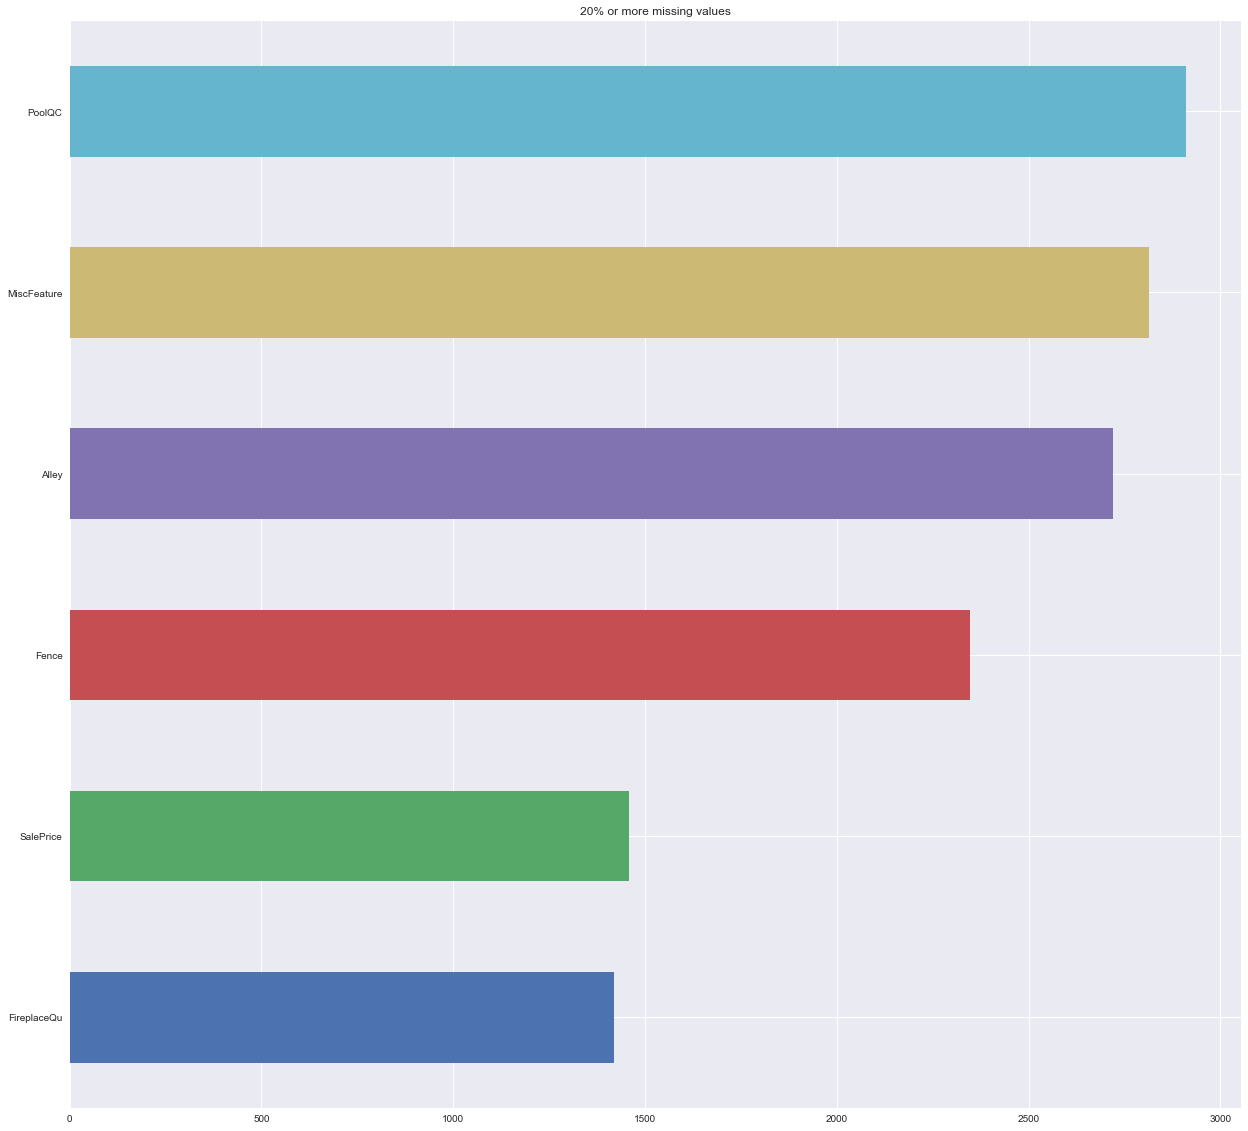

In [157]:
missing = data.apply(lambda x: sum(x.isnull())).sort_values(ascending=True)
missing[missing >= int(data.shape[0]*0.2)].plot.barh(figsize=(21,20), title="{:d}% or more missing values".format(20))

Let's investigate the distribution of the categorical variables

In [120]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
cat_count = len(categorical_columns)
cat_count

44

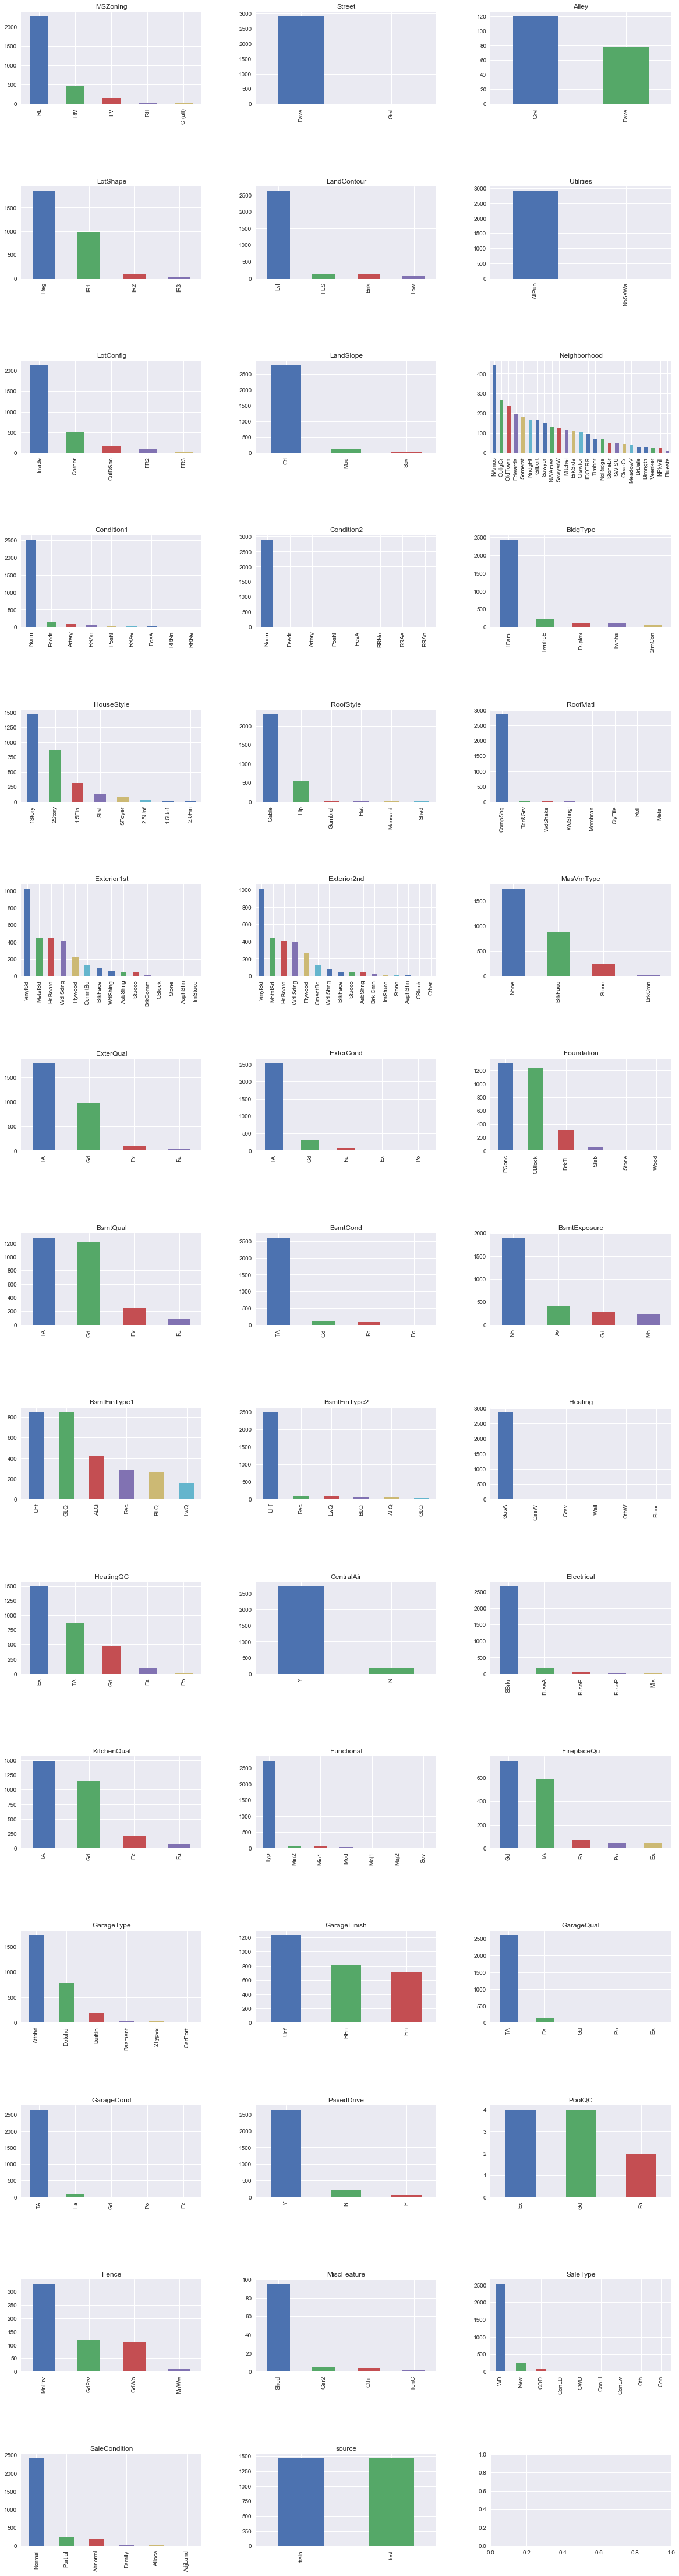

In [218]:
fig, ax = plt.subplots(15, 3, figsize=(20,80))
fig.subplots_adjust(hspace=0.9, wspace=0.3)

for axis, col in zip(ax.ravel(), categorical_columns):
    data[col].value_counts().plot.bar(ax=axis, title=col)   

- There is lots of potential for new features here. 

Let's invesgiate the distribution of the numerical variables

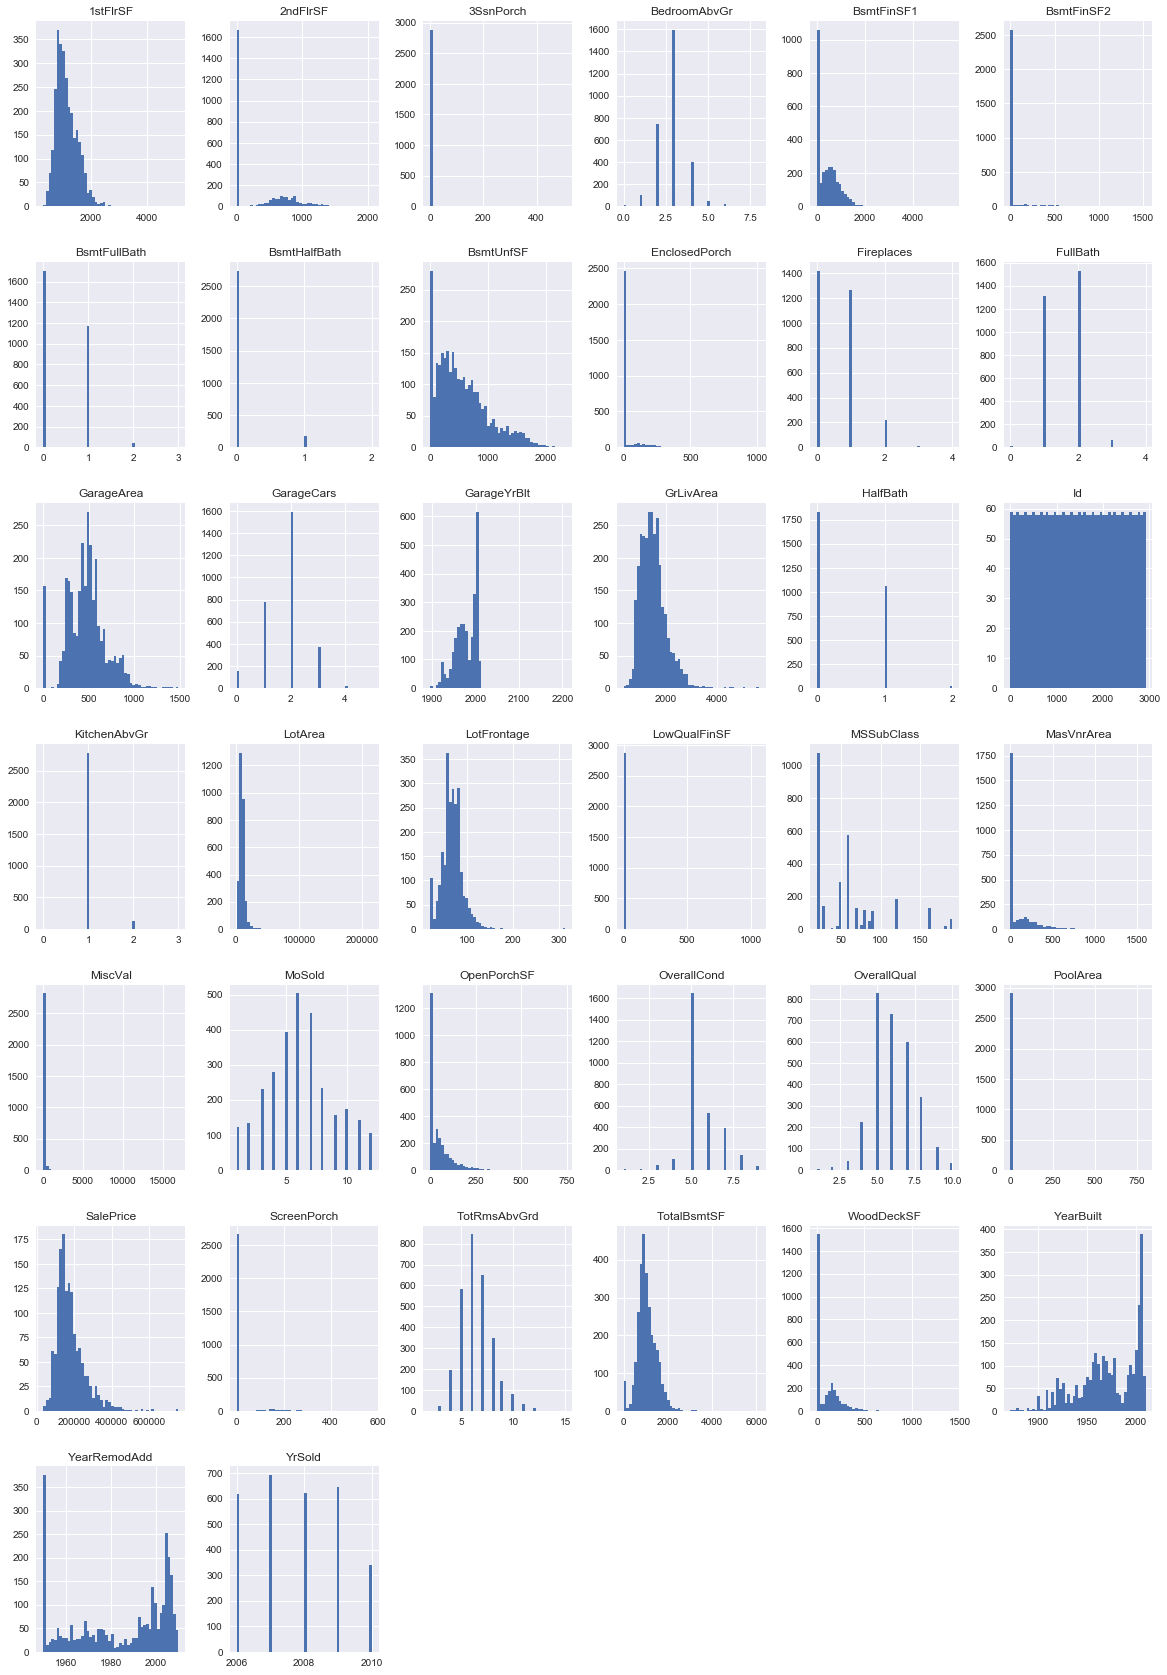

In [122]:
data.hist(bins=50, figsize=(20,30))
plt.show()

- Many columns have different scales, this will need to be handled. 
- It will be useful to transform the axis for some columns to make their distribution more normal. 

Now let's take a look at the relationship between variables and our target column `SalePrice`

In [160]:
data_corr = data.corr()

In [162]:
data_corr["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

Quite a number of columns seem to correlate well with the selling price, let's zoom in on a few specifics.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027AF49E2E80>,
      dtype=object)

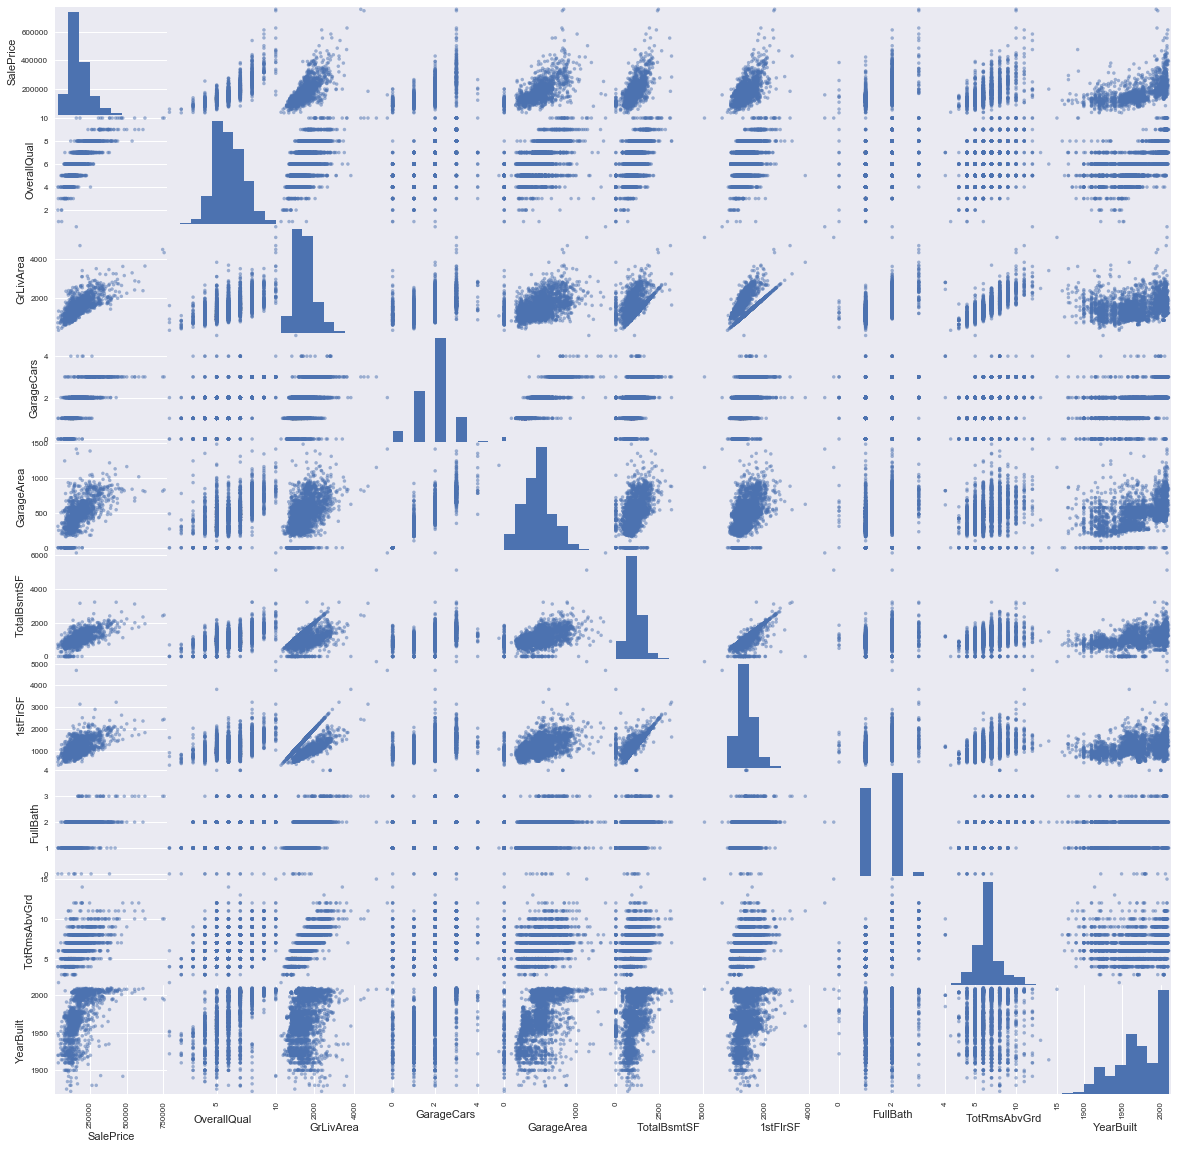

In [183]:
pd.scatter_matrix(data[data_corr["SalePrice"].sort_values(ascending=False).index[:10]], figsize=(20, 20))

# Prepare the data for Machine Learning Algorithms

In [313]:
# Used to explore a single feature on a set of subplots. 
# Visualise distribution, noise & outliers and missing values as well as correlation with target.

plt.style.use('fivethirtyeight')
def explore_variable(df, feature, target):
    
    feature_type = df[feature].dtype
    missing = df.apply(lambda x: sum(x.isnull())).loc[feature]
    print("'{}' is of type {} with {} missing values".format(feature, feature_type, missing))

    if feature_type == "object":
        fig, ax = plt.subplots(1, 2, figsize=(11,5))
        fig.subplots_adjust(wspace=0.3)

        ax1 = ax.ravel()[0]
        ax1.set_title("Distribution of {}".format(feature))
        df[feature].value_counts().plot.bar(ax=ax1)

        ax2 = ax.ravel()[1]
        ax2.set_title("Median {} by {}".format(target, feature))
        df.groupby(feature)[[target]].median().plot.bar(ax=ax2)

        plt.show()

    elif feature_type == "int64" or "float64":
        fig, ax = plt.subplots(1, 3, figsize=(15,5))
        fig.subplots_adjust(wspace=0.3)

        ax1 = ax.ravel()[0]
        ax1.set_title("Distribution of {}".format(feature))
        df[feature].hist(bins=50, ax=ax1)

        ax2 = ax.ravel()[1]
        ax2.set_title("Correlation between {} and {}".format(feature, target))
        df.plot.scatter(x=feature, y=target, ax=ax2)  

        ax3 = ax.ravel()[2]
        ax3.set_title("Box plot for {}".format(feature))
        df[feature].plot(kind="box", ax=ax3)  

        plt.show()

In [314]:
cat_attributes = [x for x in data.dtypes.index if data.dtypes[x]=='object']
num_attributes = [x for x in data.dtypes.index if data.dtypes[x]=='int64' or data.dtypes[x]=="float64"]

'MSZoning' is of type object with 4 missing values


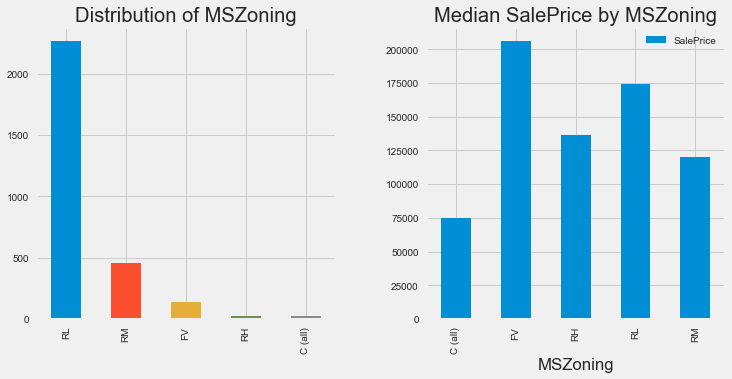

'Street' is of type object with 0 missing values


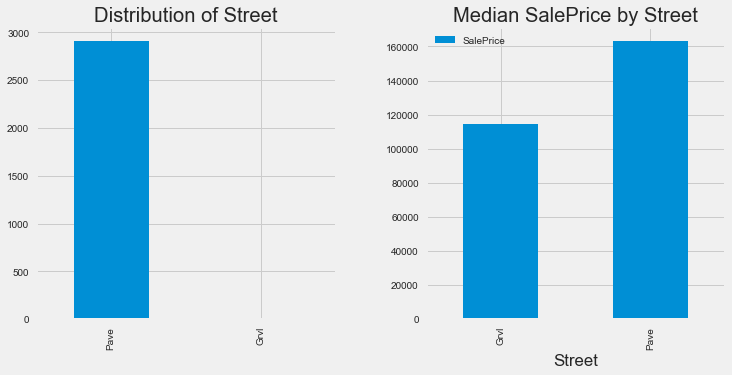

'Alley' is of type object with 2721 missing values


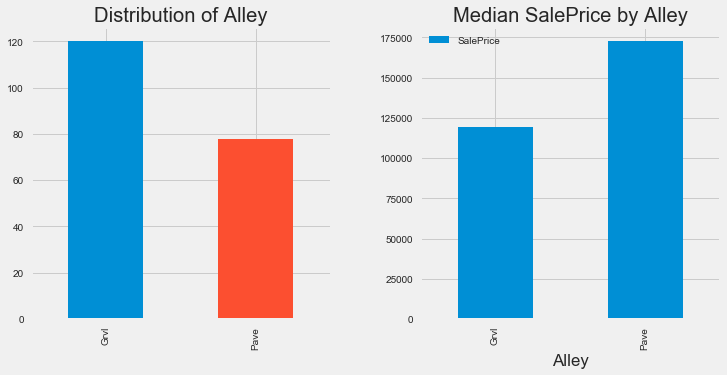

'LotShape' is of type object with 0 missing values


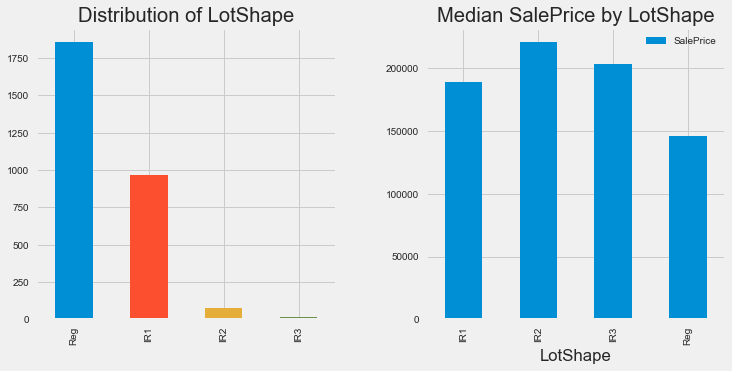

'LandContour' is of type object with 0 missing values


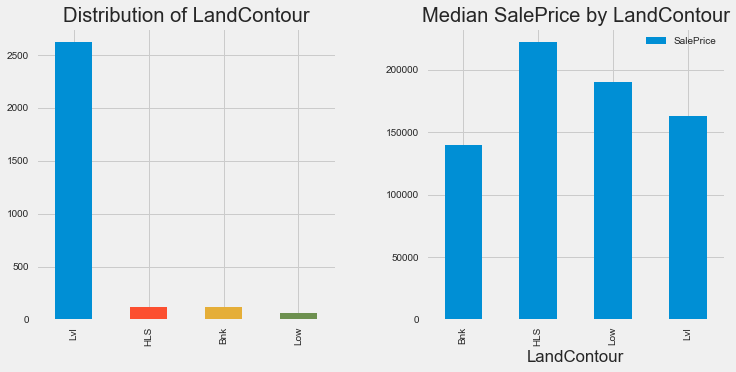

'Utilities' is of type object with 2 missing values


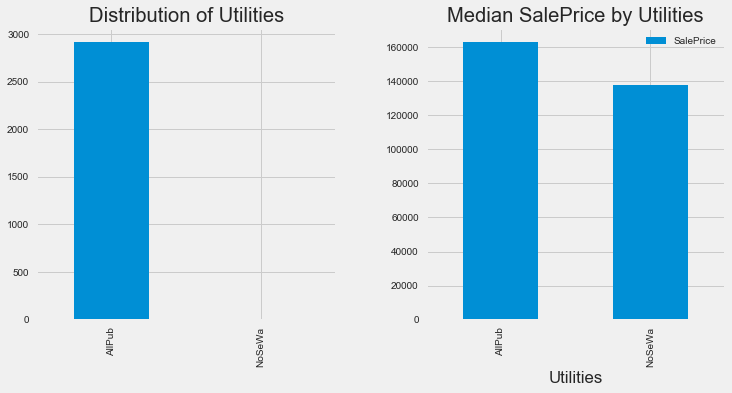

'LotConfig' is of type object with 0 missing values


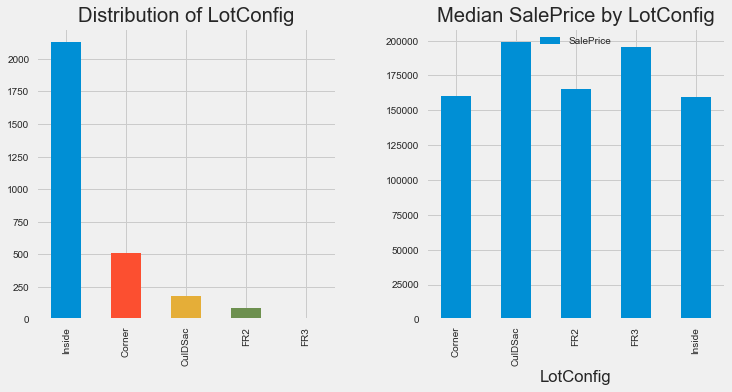

'LandSlope' is of type object with 0 missing values


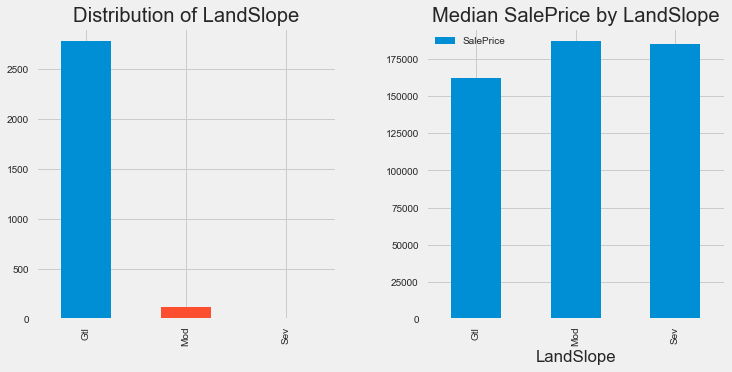

'Neighborhood' is of type object with 0 missing values


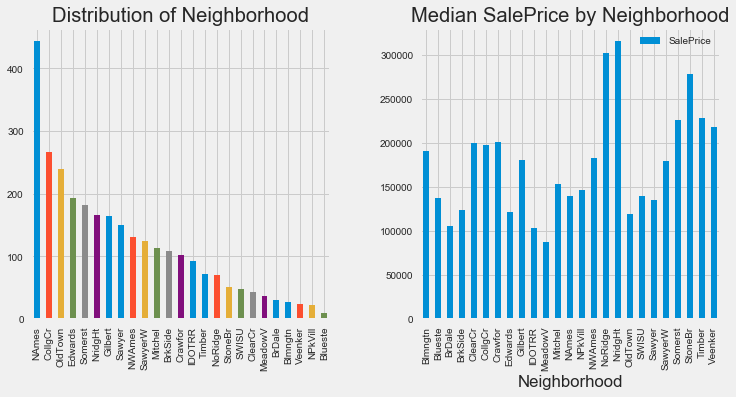

'Condition1' is of type object with 0 missing values


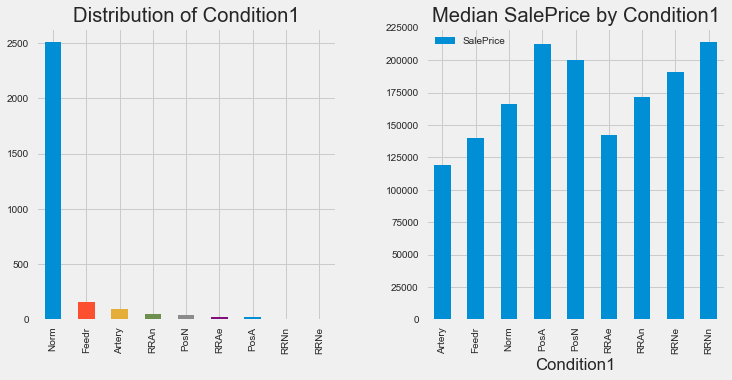

'Condition2' is of type object with 0 missing values


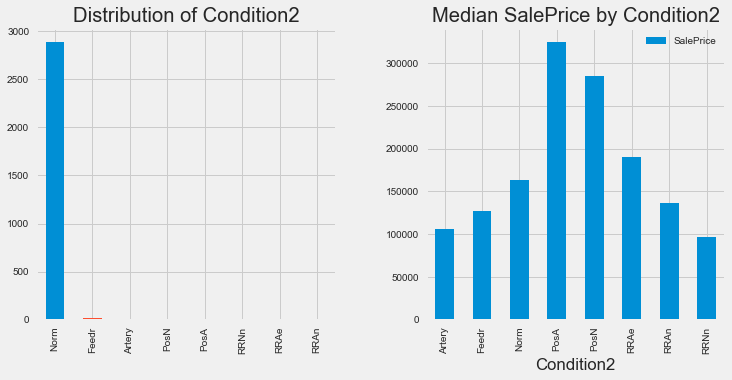

'BldgType' is of type object with 0 missing values


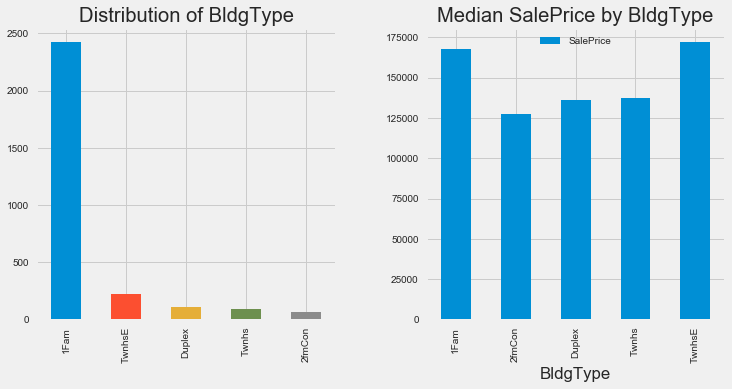

'HouseStyle' is of type object with 0 missing values


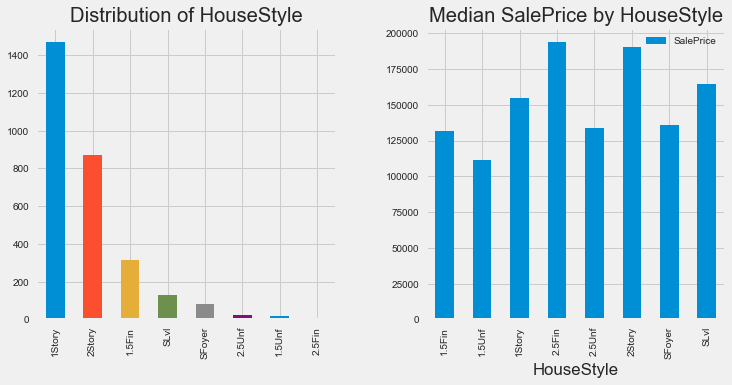

'RoofStyle' is of type object with 0 missing values


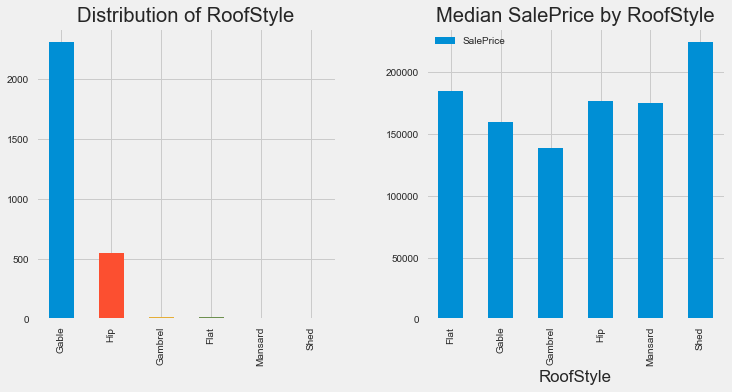

'RoofMatl' is of type object with 0 missing values


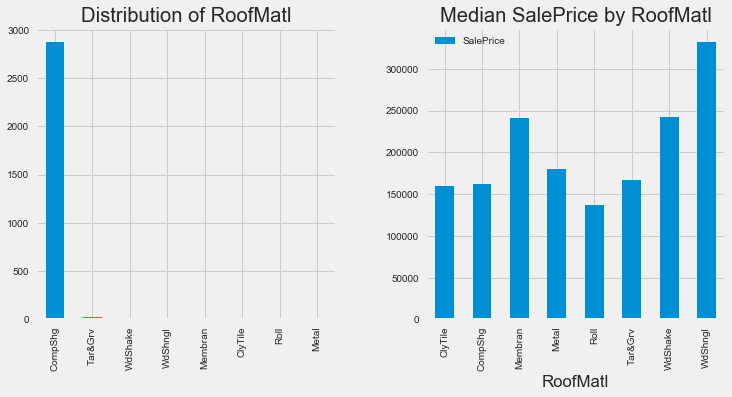

'Exterior1st' is of type object with 1 missing values


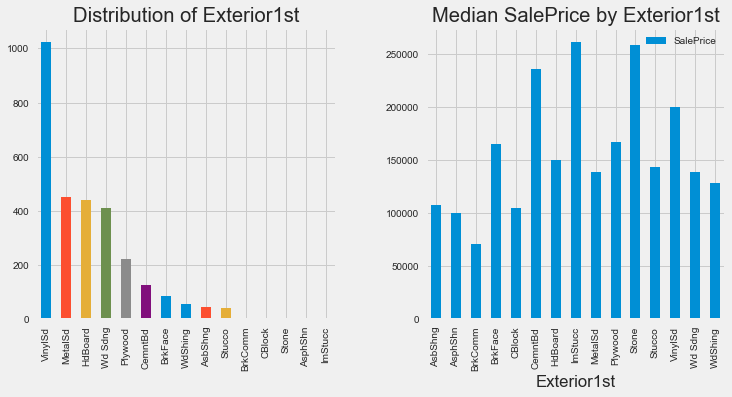

'Exterior2nd' is of type object with 1 missing values


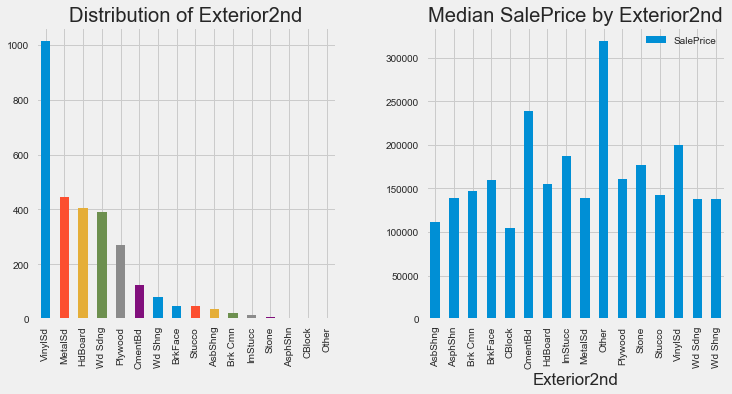

'MasVnrType' is of type object with 24 missing values


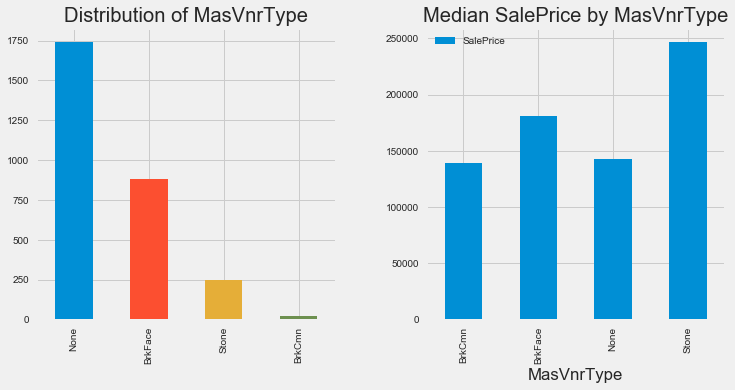

'ExterQual' is of type object with 0 missing values


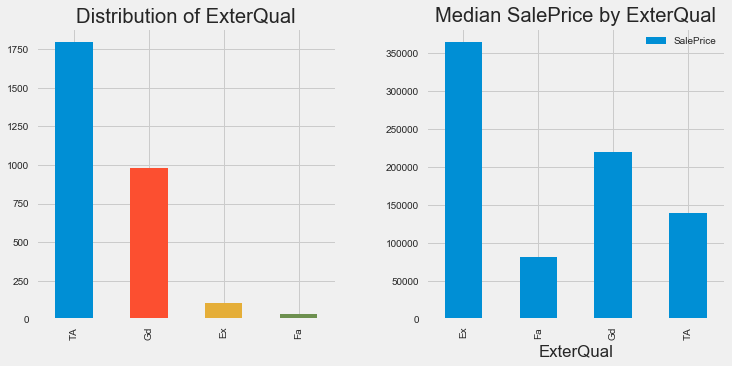

'ExterCond' is of type object with 0 missing values


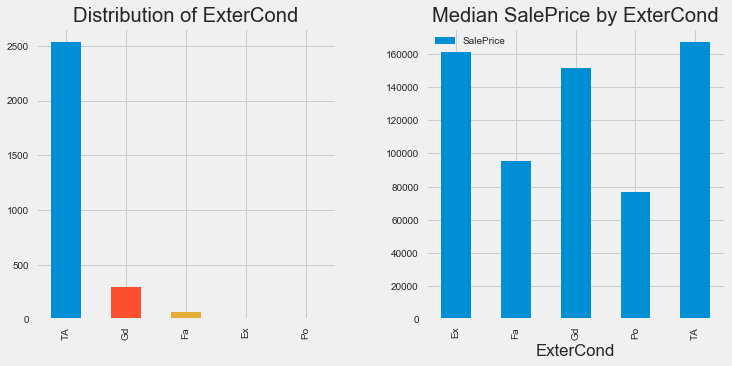

'Foundation' is of type object with 0 missing values


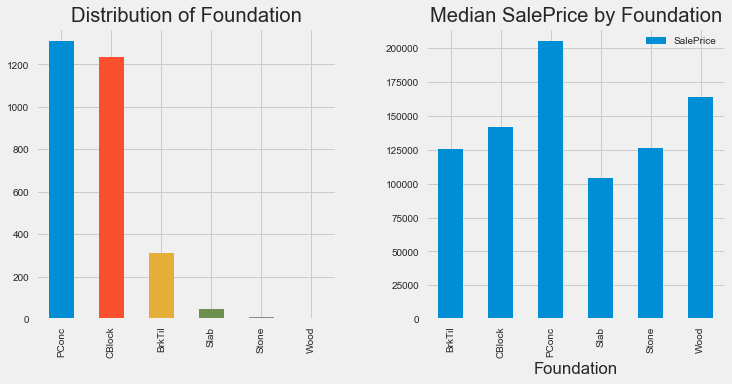

'BsmtQual' is of type object with 81 missing values


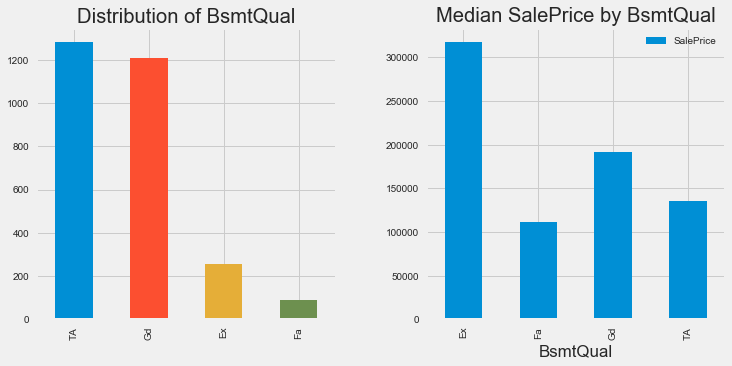

'BsmtCond' is of type object with 82 missing values


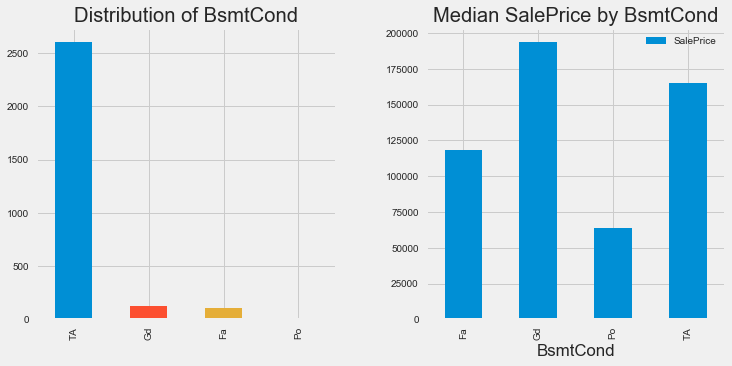

'BsmtExposure' is of type object with 82 missing values


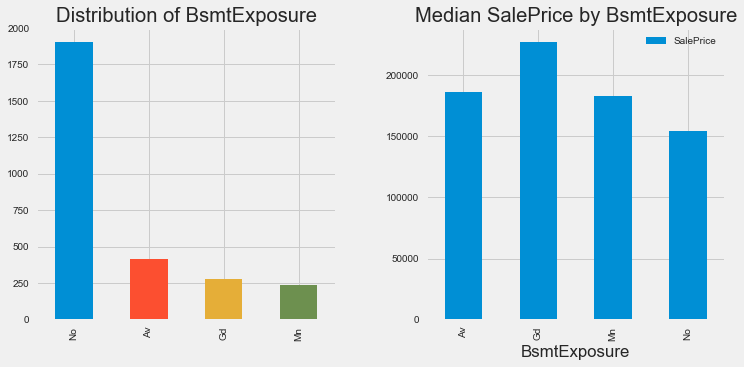

'BsmtFinType1' is of type object with 79 missing values


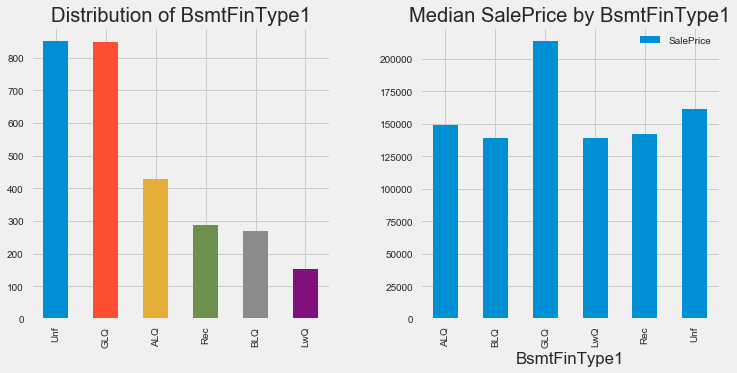

'BsmtFinType2' is of type object with 80 missing values


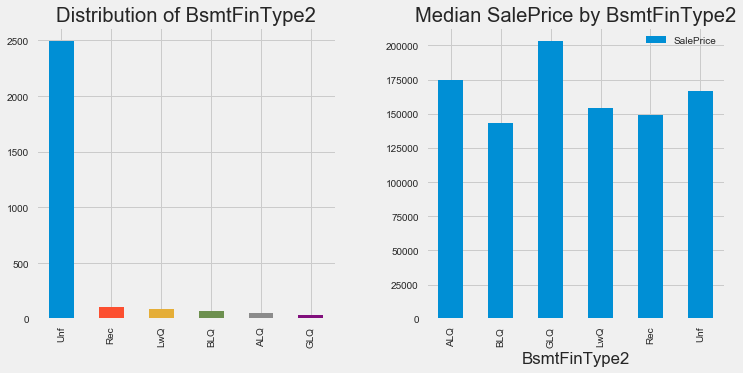

'Heating' is of type object with 0 missing values


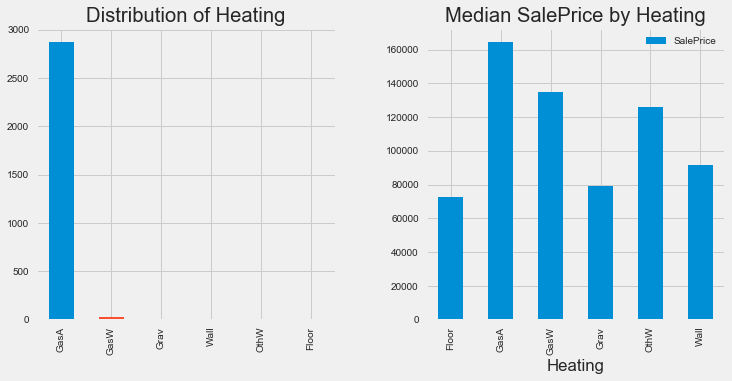

'HeatingQC' is of type object with 0 missing values


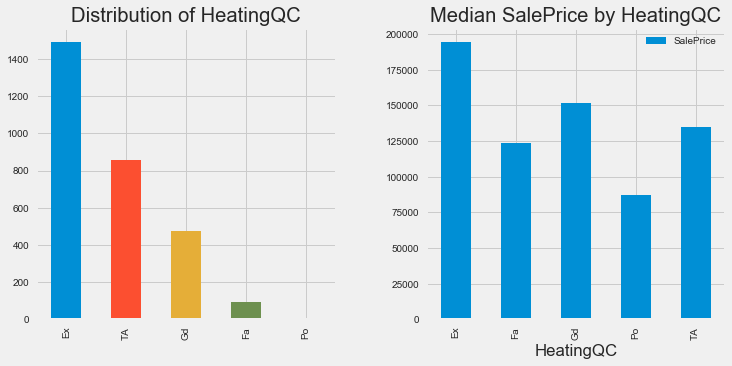

'CentralAir' is of type object with 0 missing values


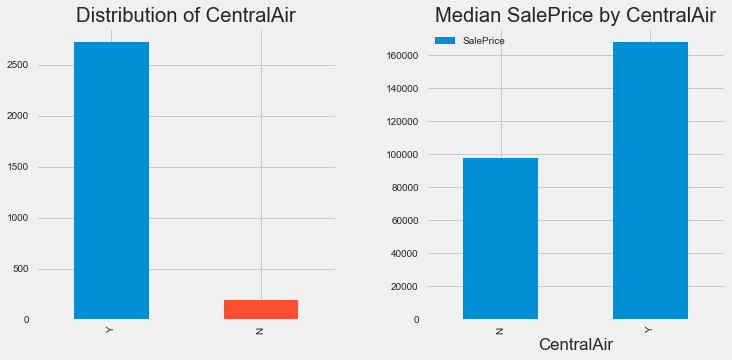

'Electrical' is of type object with 1 missing values


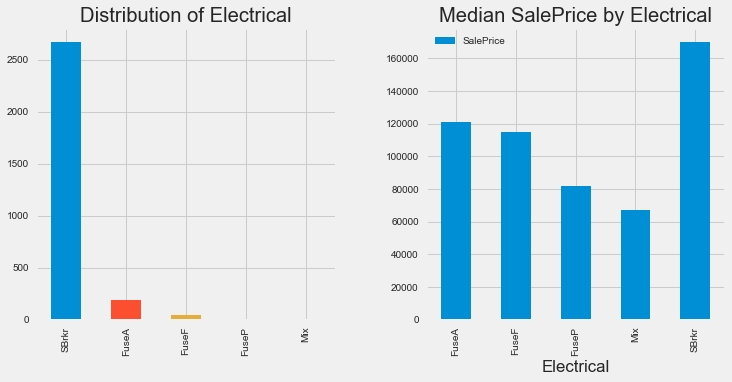

'KitchenQual' is of type object with 1 missing values


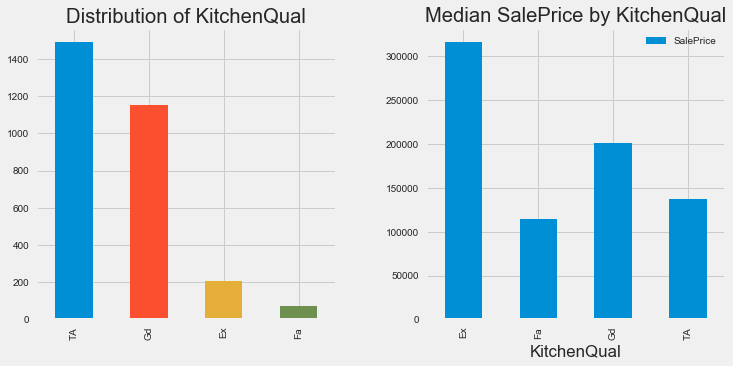

'Functional' is of type object with 2 missing values


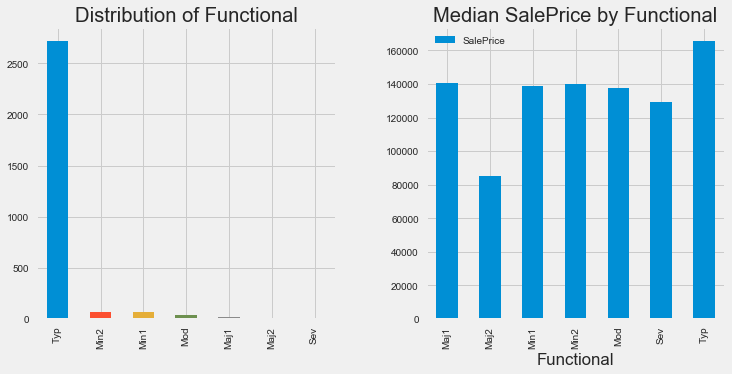

'FireplaceQu' is of type object with 1420 missing values


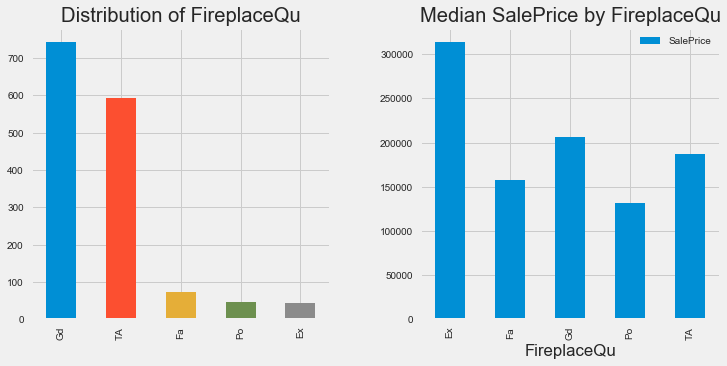

'GarageType' is of type object with 157 missing values


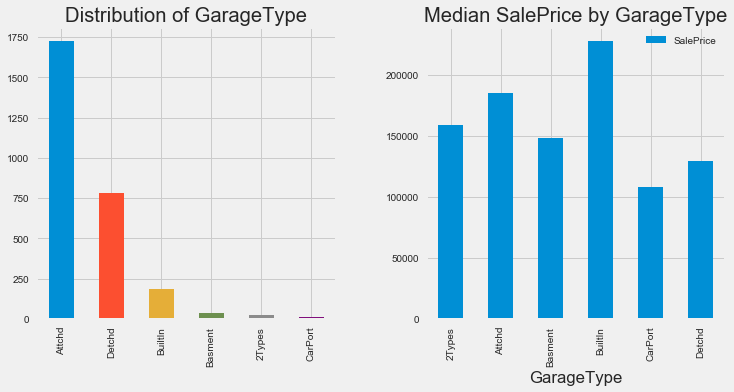

'GarageFinish' is of type object with 159 missing values


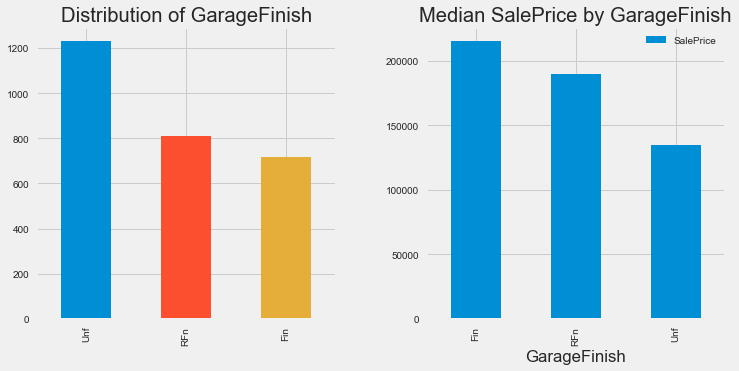

'GarageQual' is of type object with 159 missing values


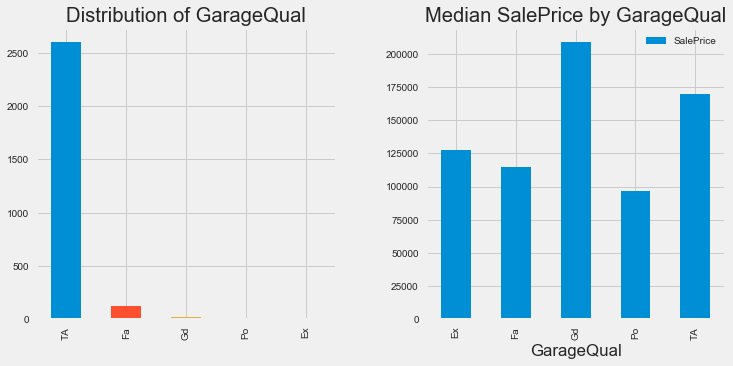

'GarageCond' is of type object with 159 missing values


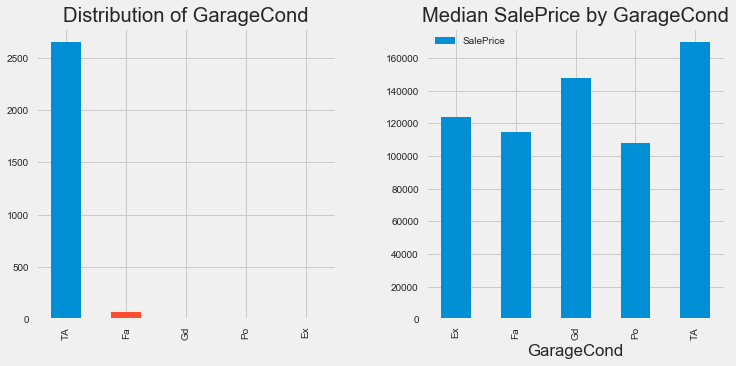

'PavedDrive' is of type object with 0 missing values


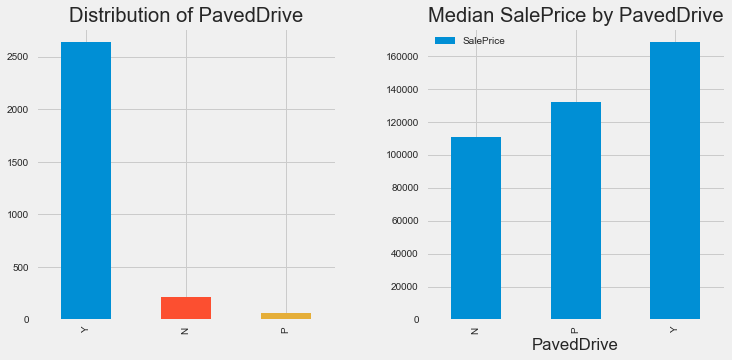

'PoolQC' is of type object with 2909 missing values


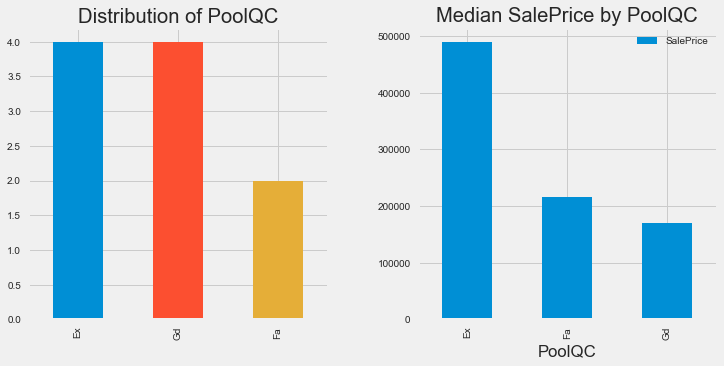

'Fence' is of type object with 2348 missing values


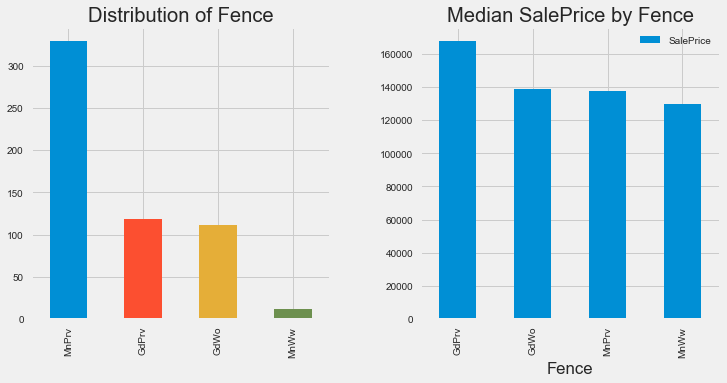

'MiscFeature' is of type object with 2814 missing values


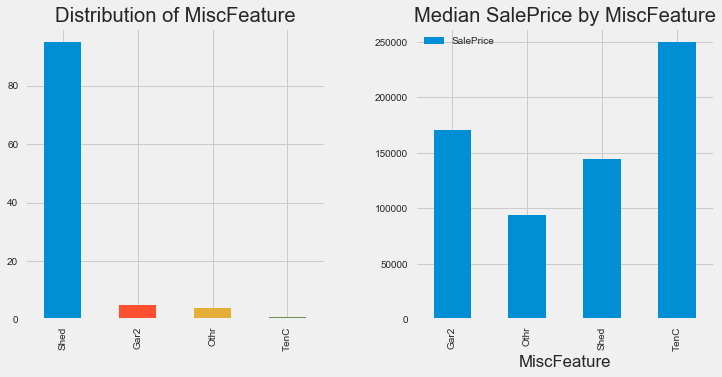

'SaleType' is of type object with 1 missing values


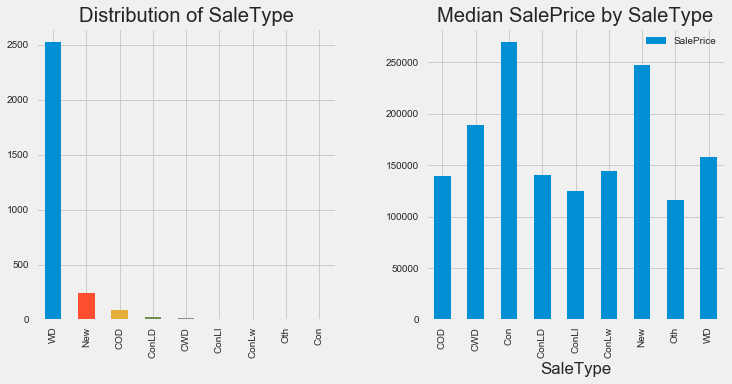

'SaleCondition' is of type object with 0 missing values


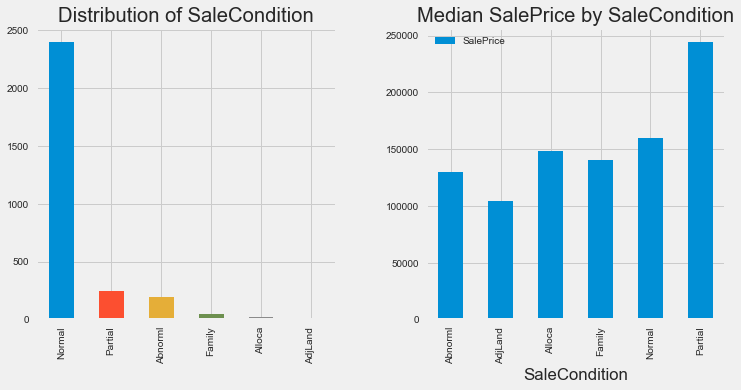

'source' is of type object with 0 missing values


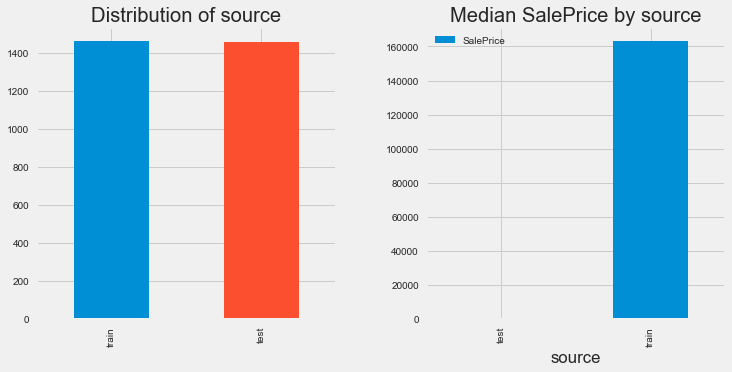

In [315]:
target="SalePrice"
for feature in cat_attributes:
    explore_variable(data, feature, target)

- Most houses are zoned as residential low density but floating villages attract the highest selling price. `MSZoning` has 4 missing values
- 

'Id' is of type int64 with 0 missing values


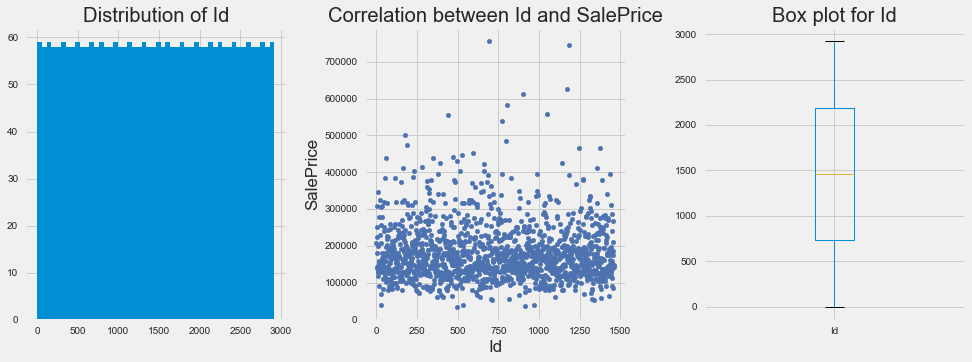

'MSSubClass' is of type int64 with 0 missing values


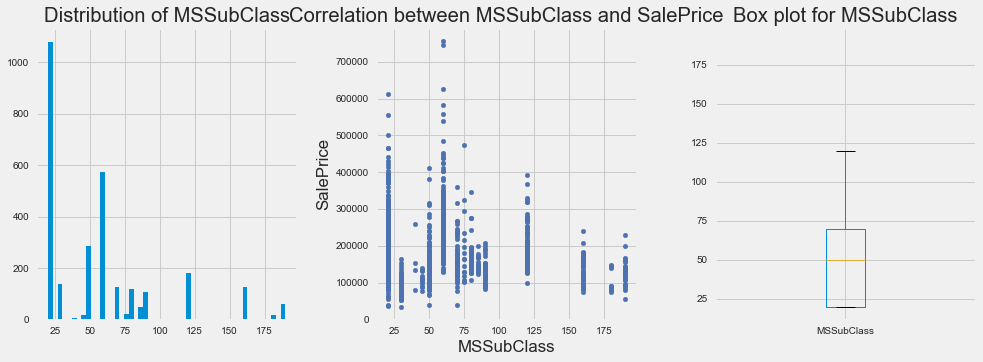

'LotFrontage' is of type float64 with 486 missing values


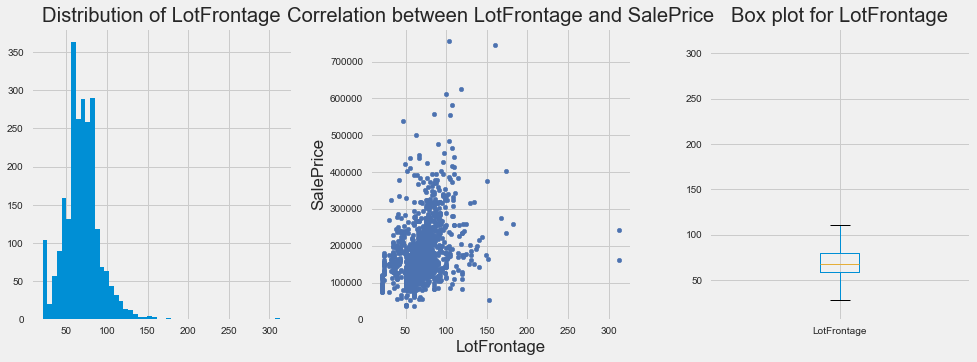

'LotArea' is of type int64 with 0 missing values


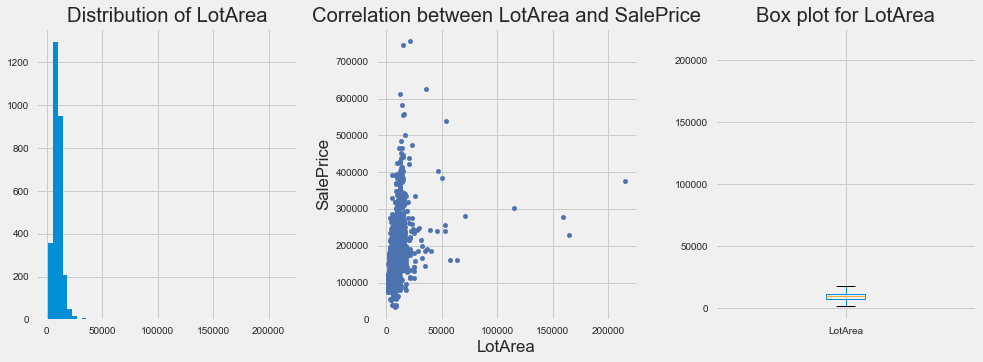

'OverallQual' is of type int64 with 0 missing values


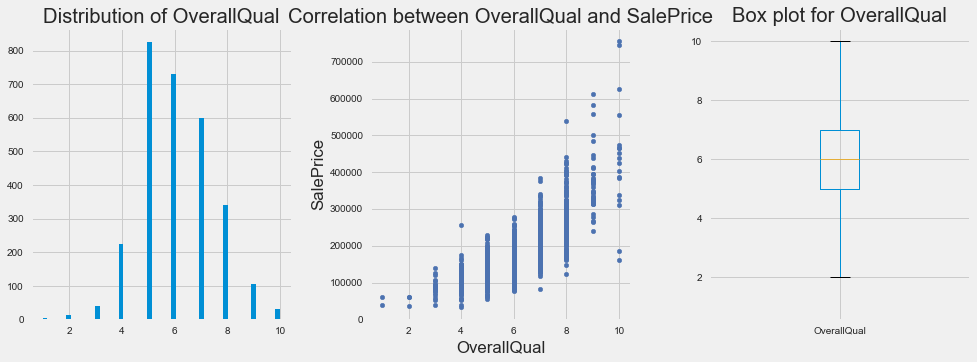

'OverallCond' is of type int64 with 0 missing values


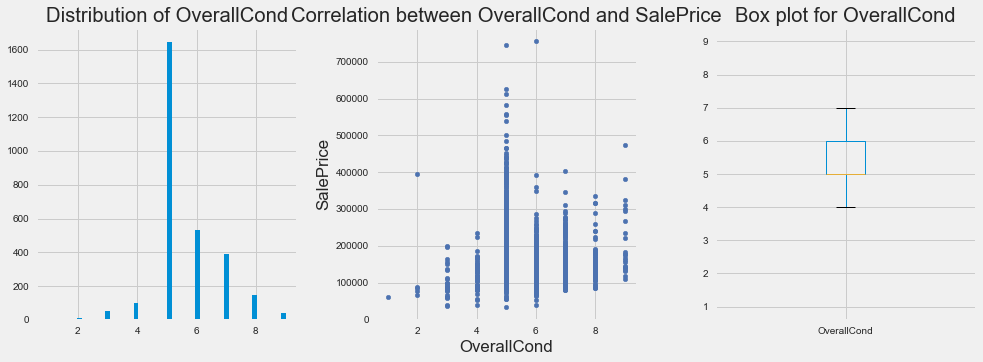

'YearBuilt' is of type int64 with 0 missing values


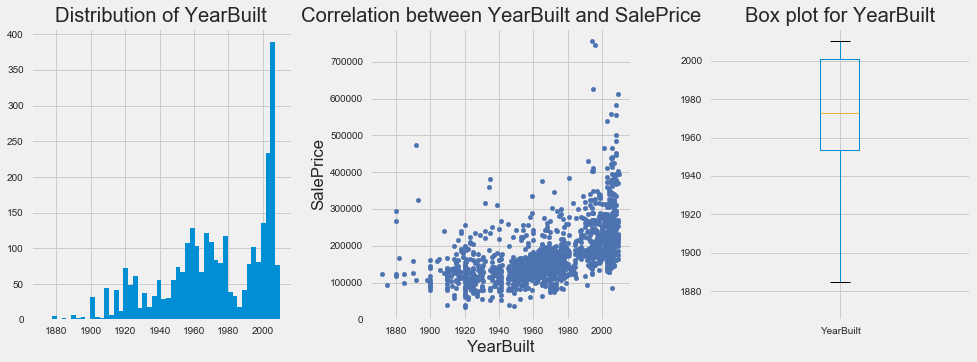

'YearRemodAdd' is of type int64 with 0 missing values


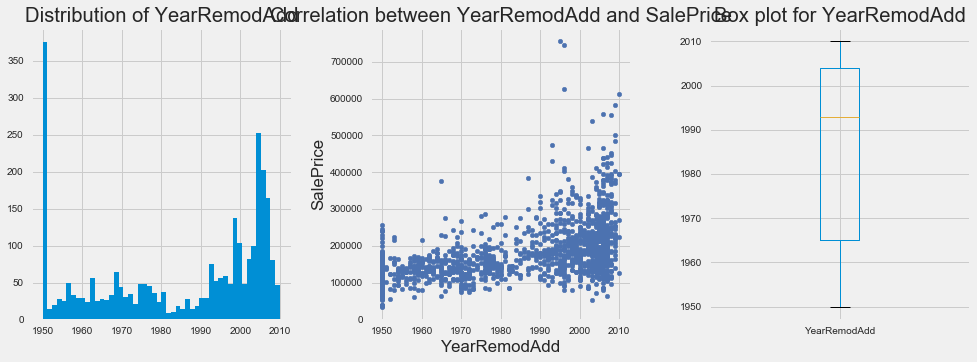

'MasVnrArea' is of type float64 with 23 missing values


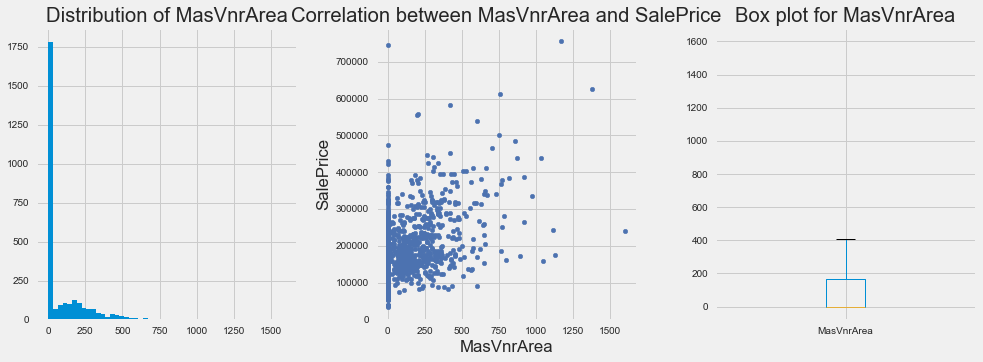

'BsmtFinSF1' is of type float64 with 1 missing values


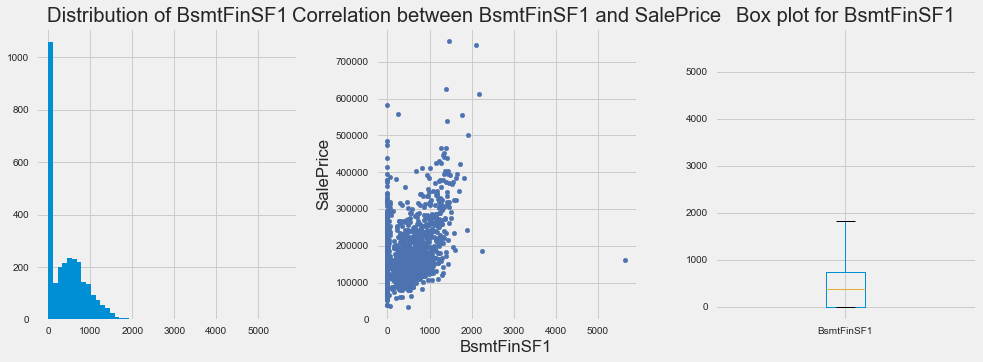

'BsmtFinSF2' is of type float64 with 1 missing values


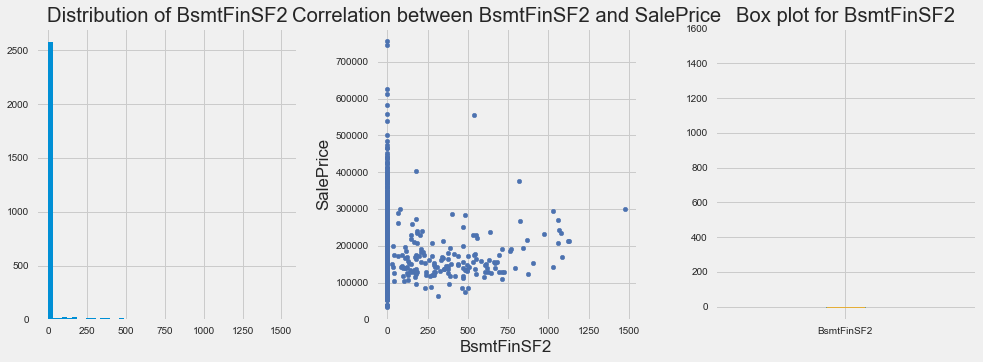

'BsmtUnfSF' is of type float64 with 1 missing values


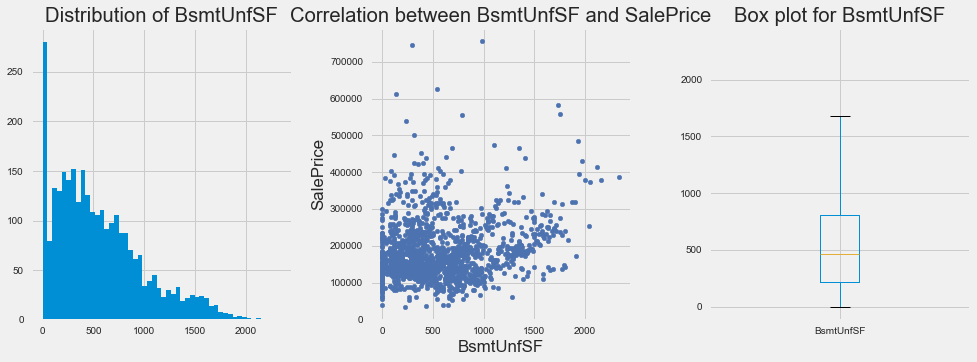

'TotalBsmtSF' is of type float64 with 1 missing values


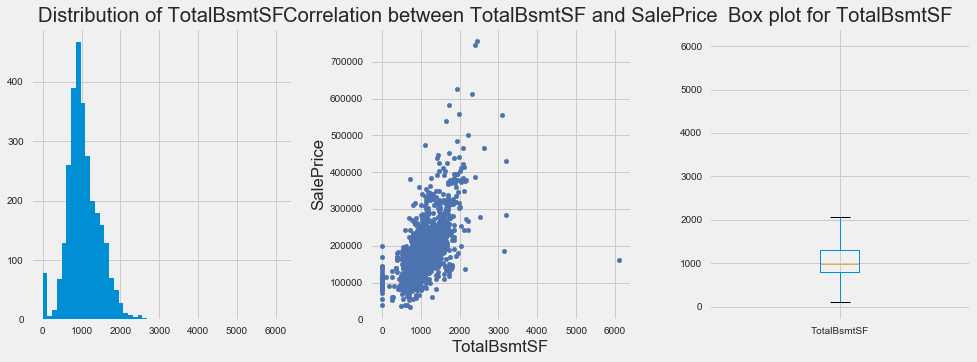

'1stFlrSF' is of type int64 with 0 missing values


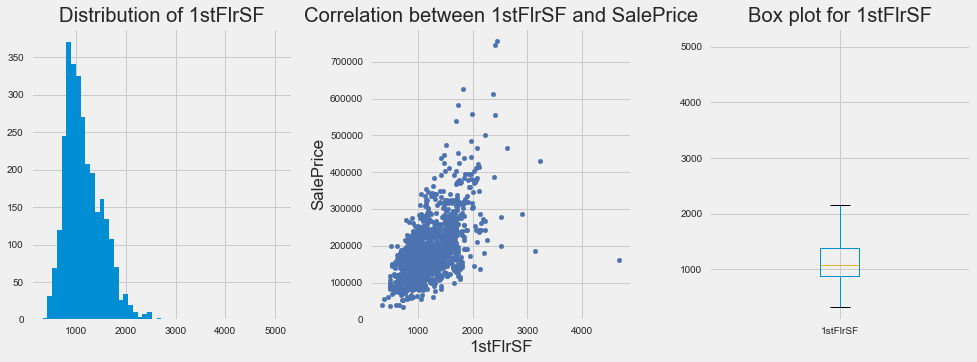

'2ndFlrSF' is of type int64 with 0 missing values


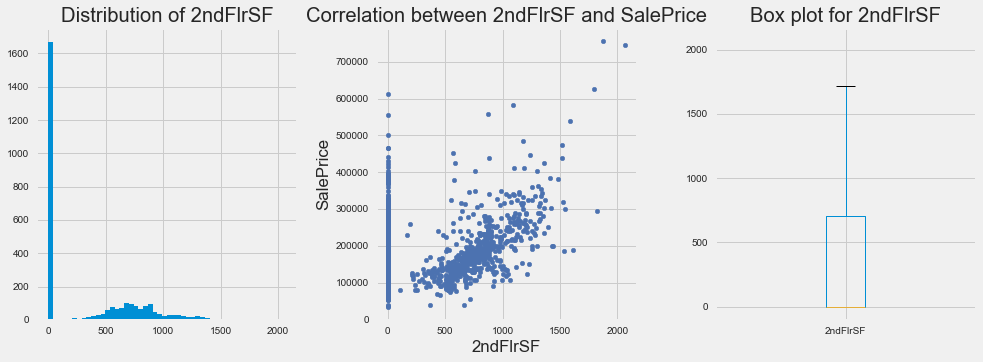

'LowQualFinSF' is of type int64 with 0 missing values


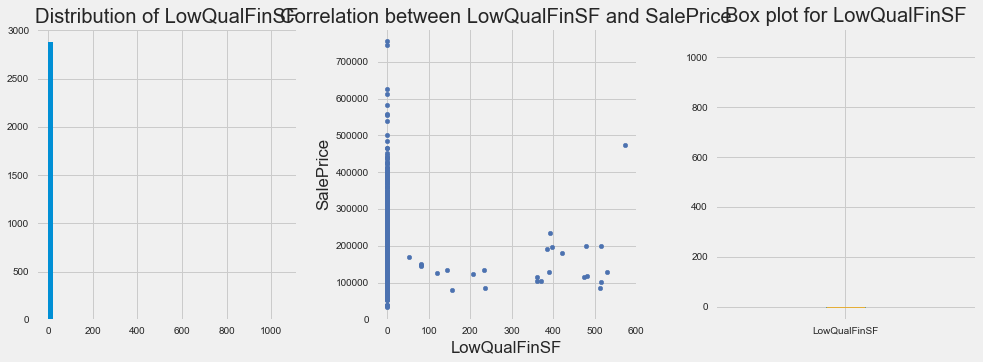

'GrLivArea' is of type int64 with 0 missing values


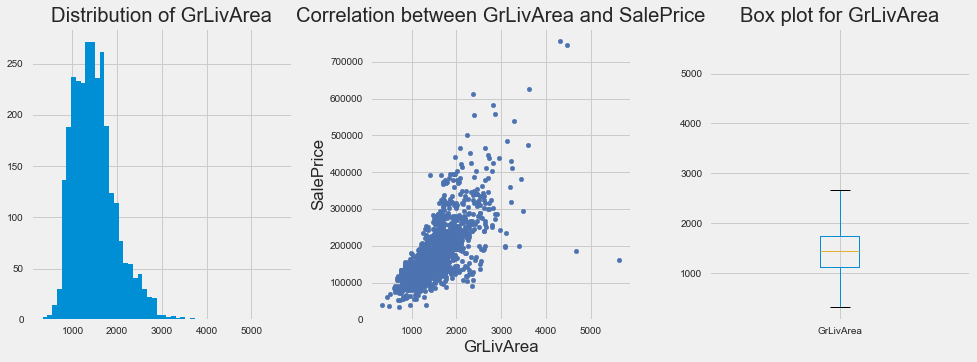

'BsmtFullBath' is of type float64 with 2 missing values


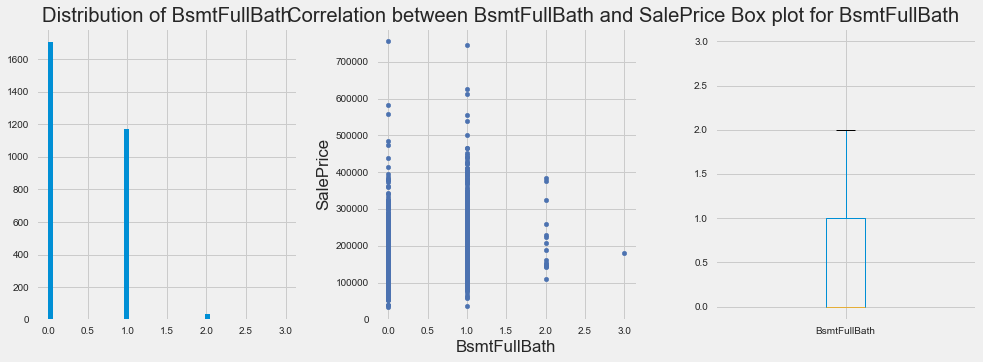

'BsmtHalfBath' is of type float64 with 2 missing values


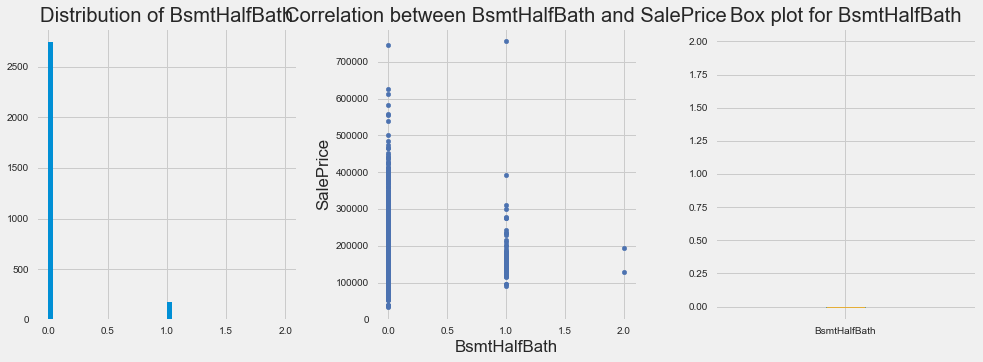

'FullBath' is of type int64 with 0 missing values


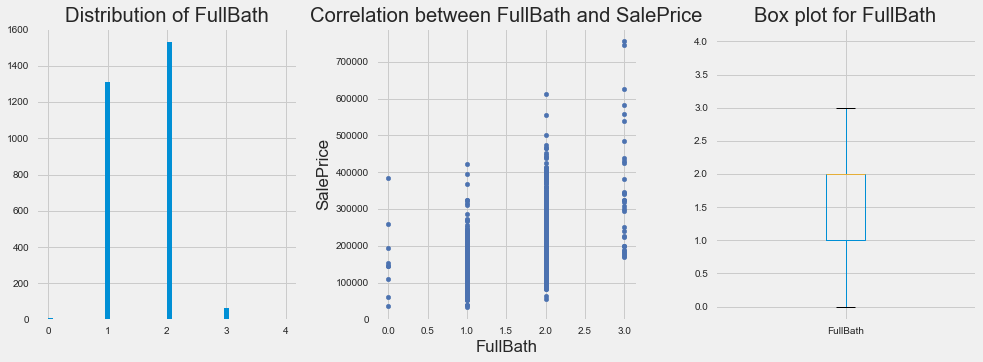

'HalfBath' is of type int64 with 0 missing values


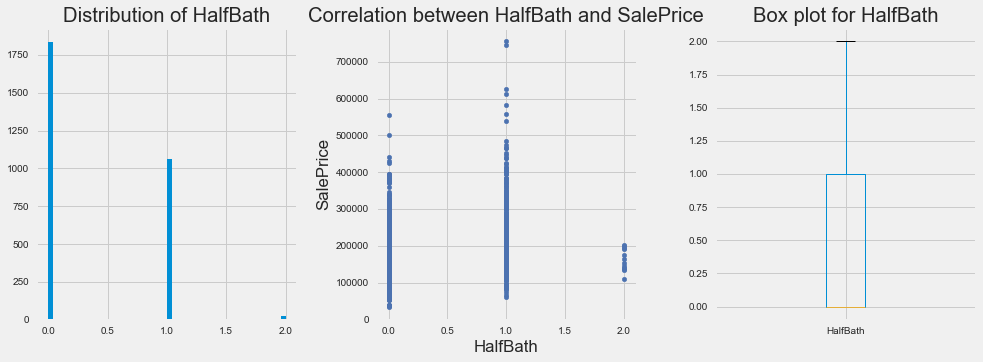

'BedroomAbvGr' is of type int64 with 0 missing values


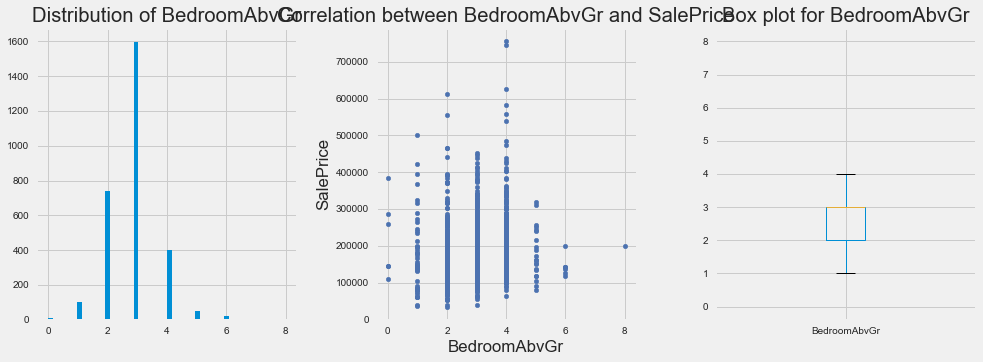

'KitchenAbvGr' is of type int64 with 0 missing values


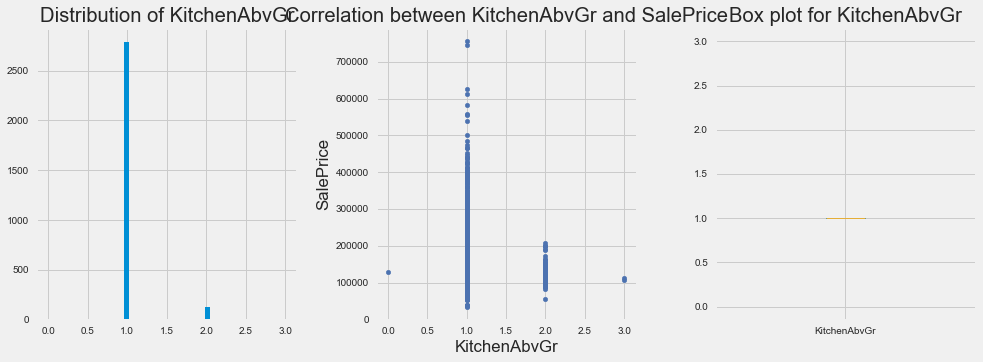

'TotRmsAbvGrd' is of type int64 with 0 missing values


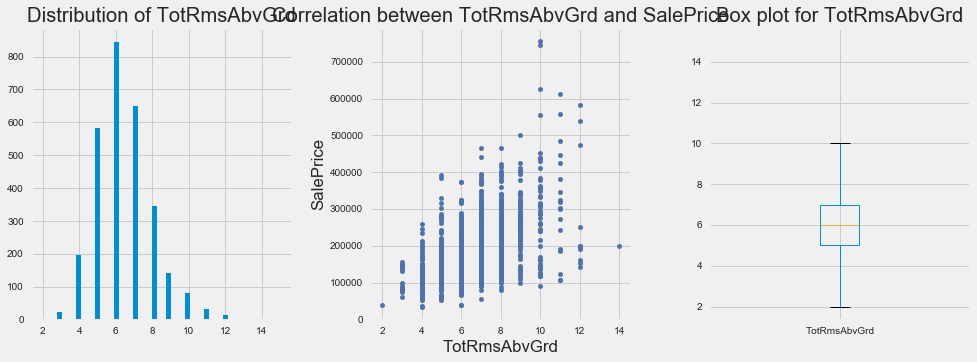

'Fireplaces' is of type int64 with 0 missing values


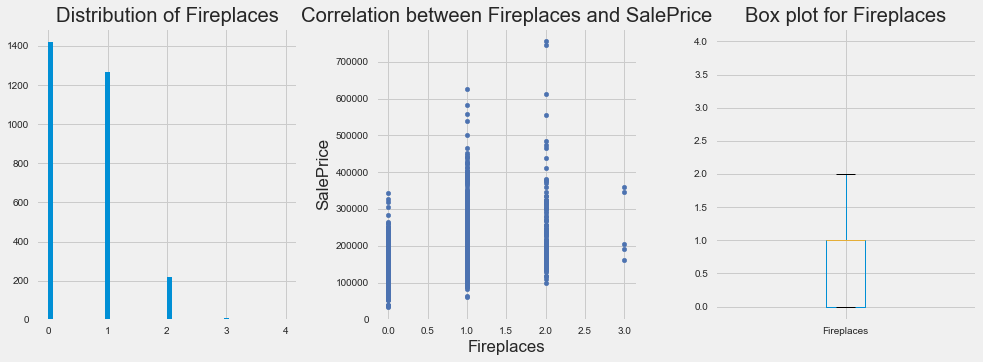

'GarageYrBlt' is of type float64 with 159 missing values


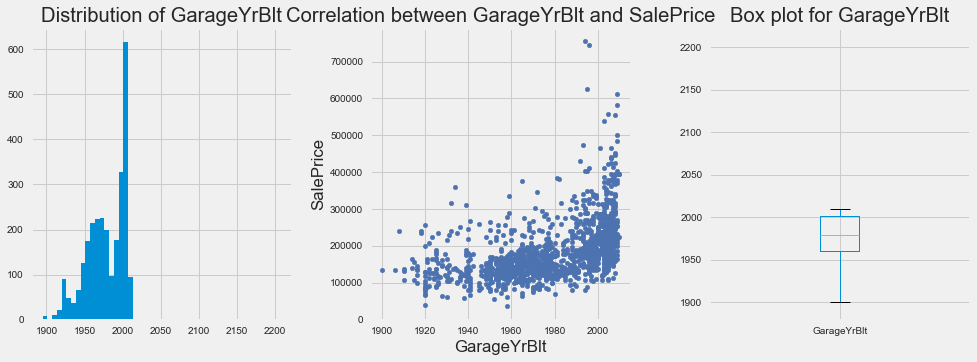

'GarageCars' is of type float64 with 1 missing values


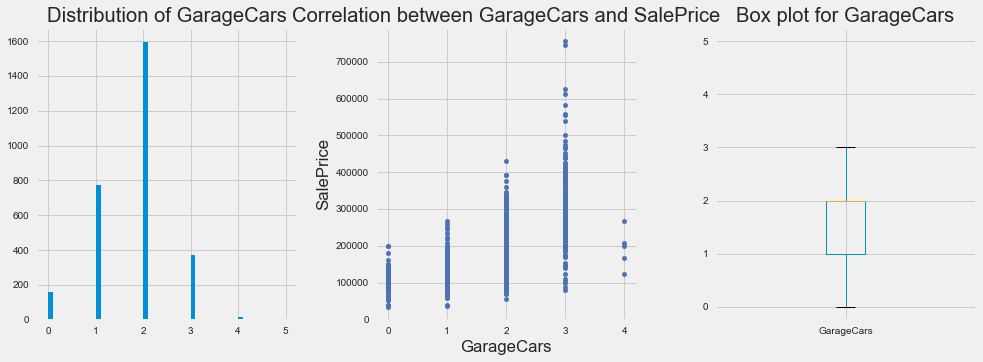

'GarageArea' is of type float64 with 1 missing values


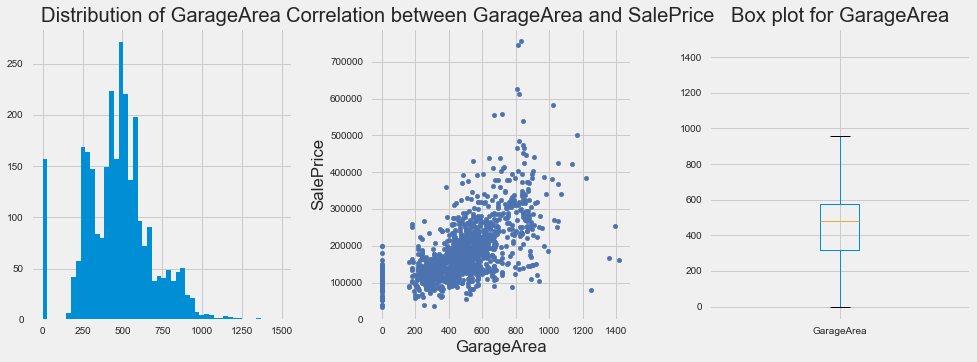

'WoodDeckSF' is of type int64 with 0 missing values


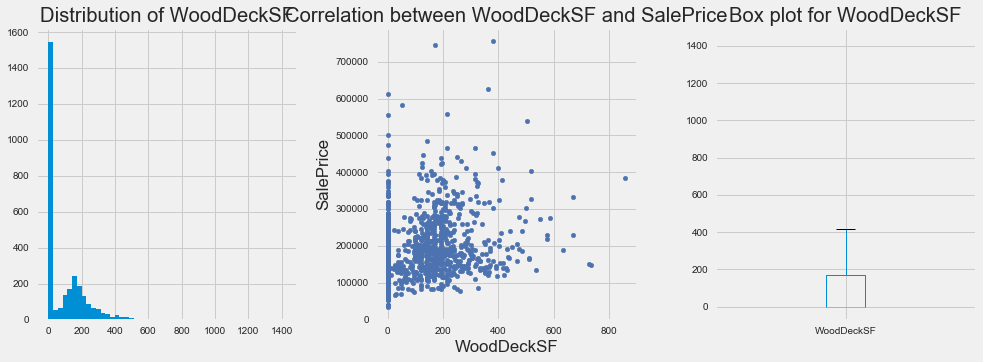

'OpenPorchSF' is of type int64 with 0 missing values


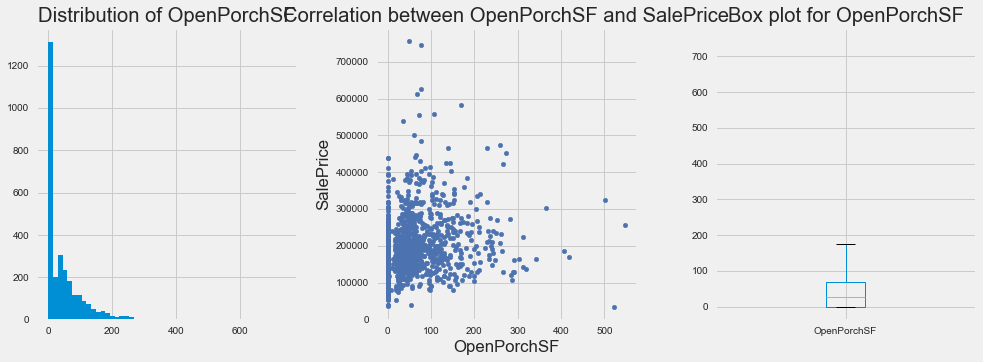

'EnclosedPorch' is of type int64 with 0 missing values


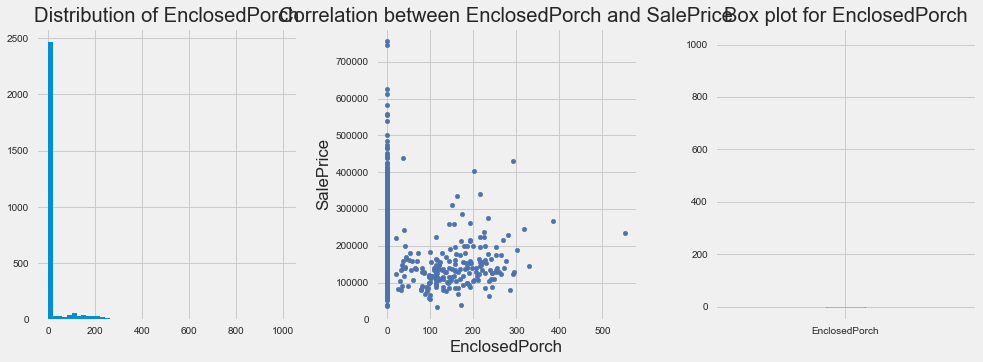

'3SsnPorch' is of type int64 with 0 missing values


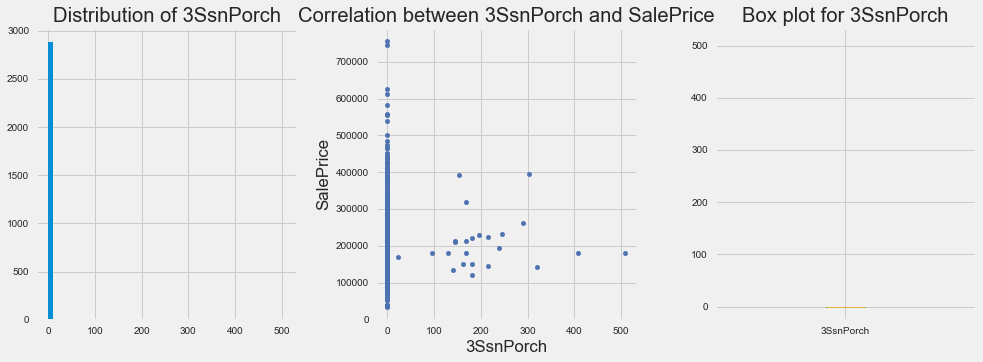

'ScreenPorch' is of type int64 with 0 missing values


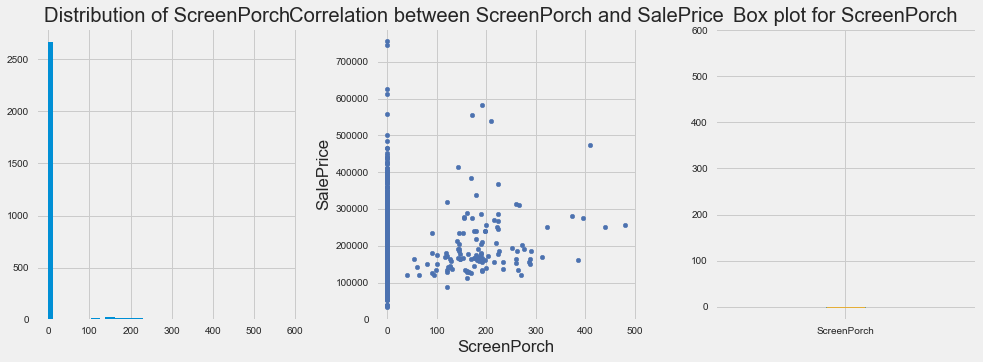

'PoolArea' is of type int64 with 0 missing values


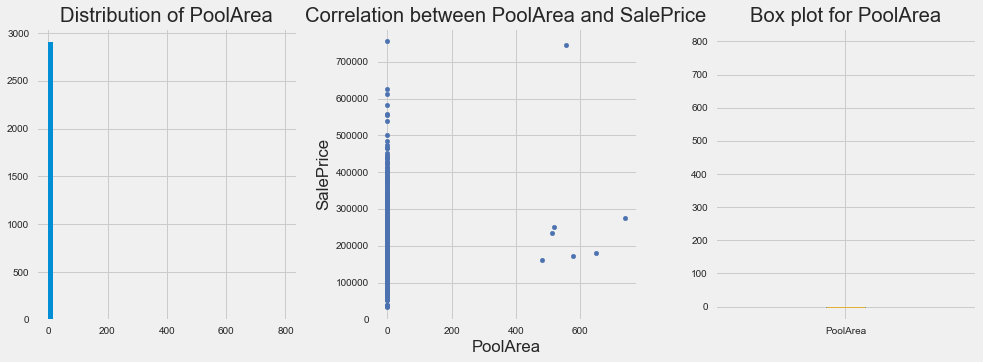

'MiscVal' is of type int64 with 0 missing values


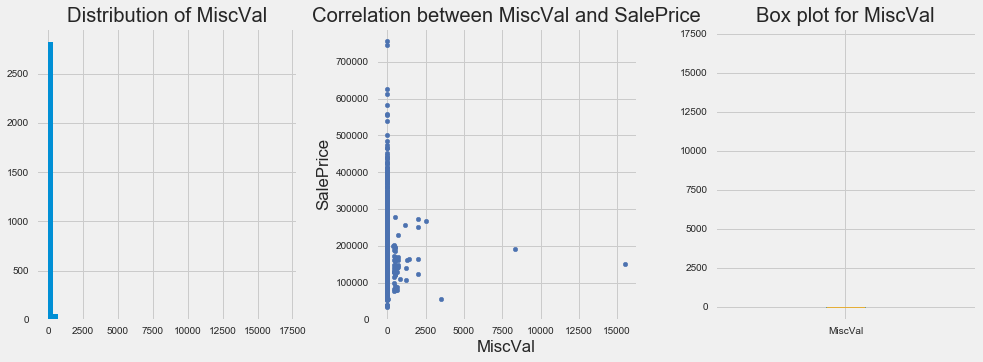

'MoSold' is of type int64 with 0 missing values


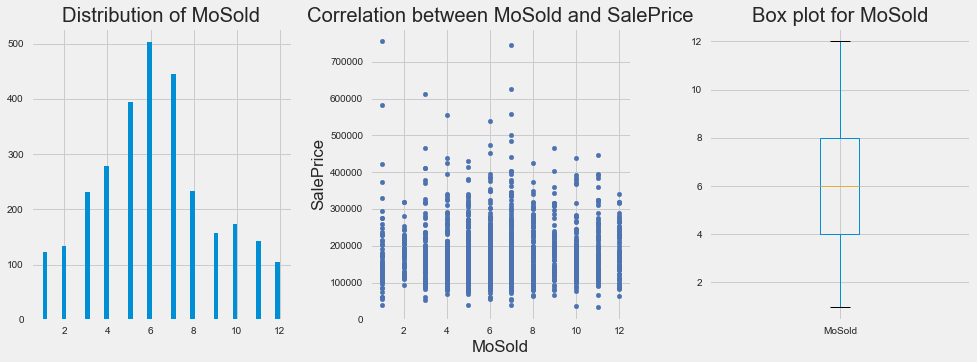

'YrSold' is of type int64 with 0 missing values


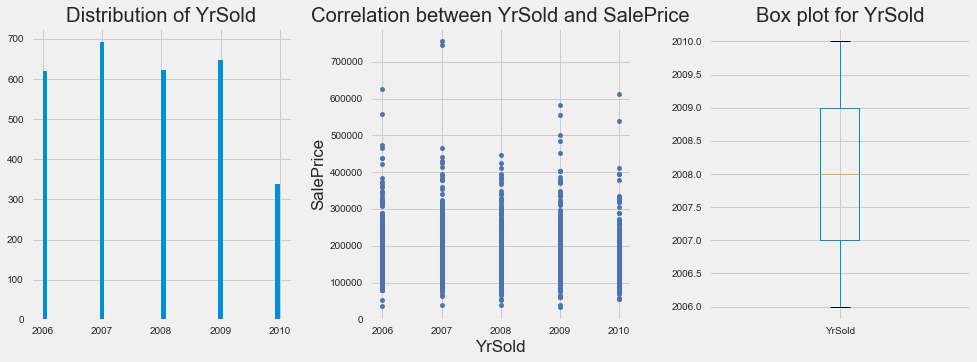

'SalePrice' is of type float64 with 1459 missing values


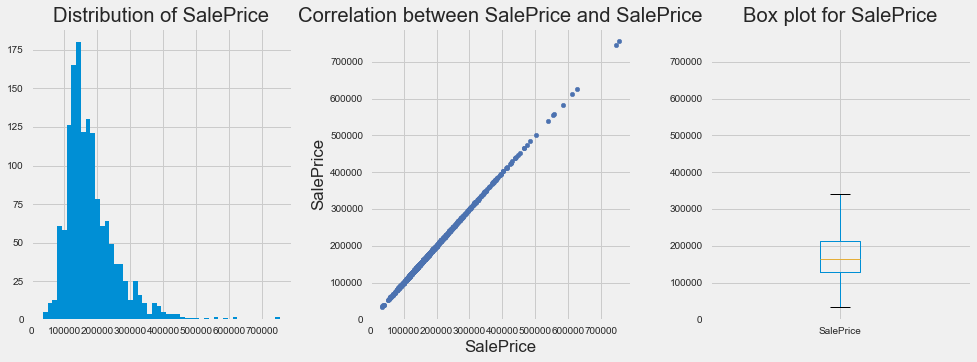

In [316]:
target="SalePrice"
for feature in num_attributes:
    explore_variable(data, feature, target)

In [258]:
top10_attributes = data_corr["SalePrice"].sort_values(ascending=False).index.values[:10]
top10_attributes

array(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath',
       'TotRmsAbvGrd', 'YearBuilt'], dtype=object)

Feature SalePrice is of type float64 with 1459 missing values


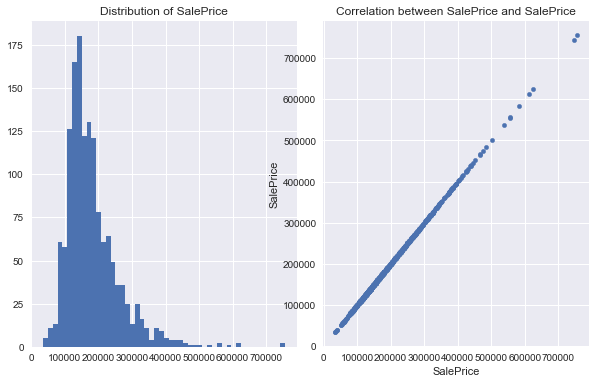

Feature OverallQual is of type int64 with 0 missing values


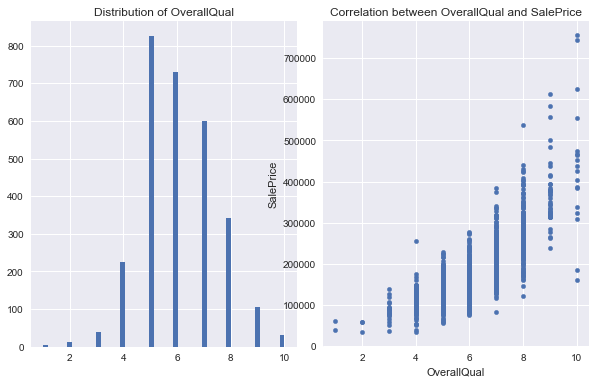

Feature GrLivArea is of type int64 with 0 missing values


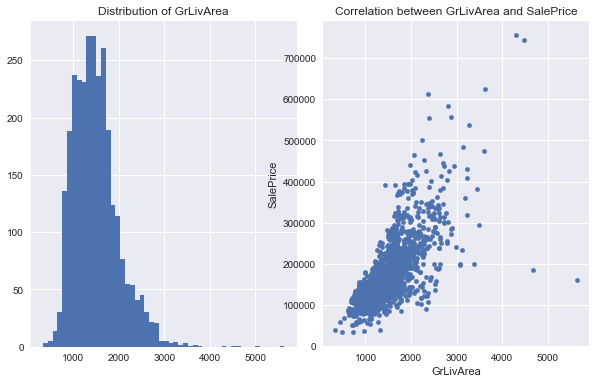

Feature GarageCars is of type float64 with 1 missing values


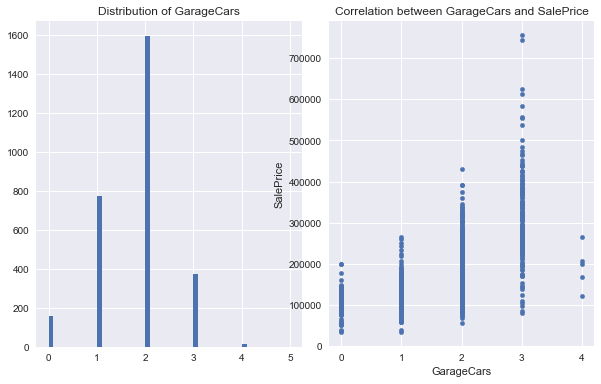

Feature GarageArea is of type float64 with 1 missing values


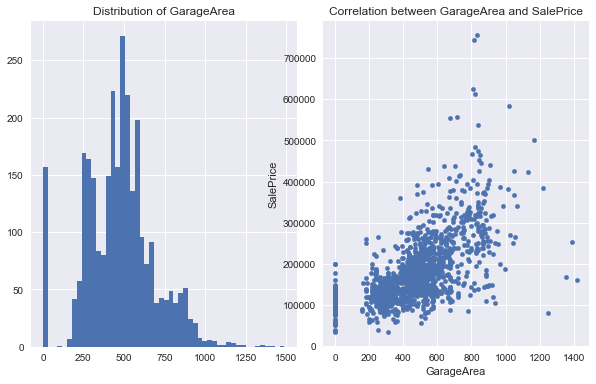

Feature TotalBsmtSF is of type float64 with 1 missing values


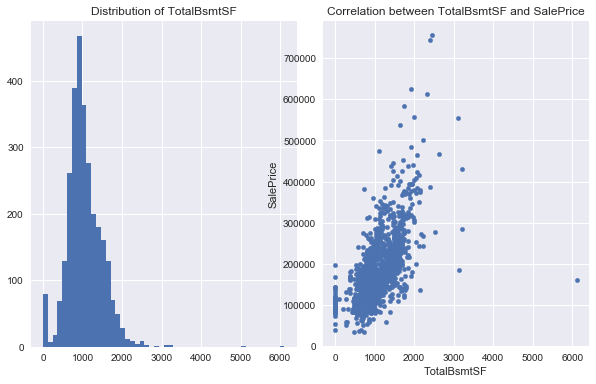

Feature 1stFlrSF is of type int64 with 0 missing values


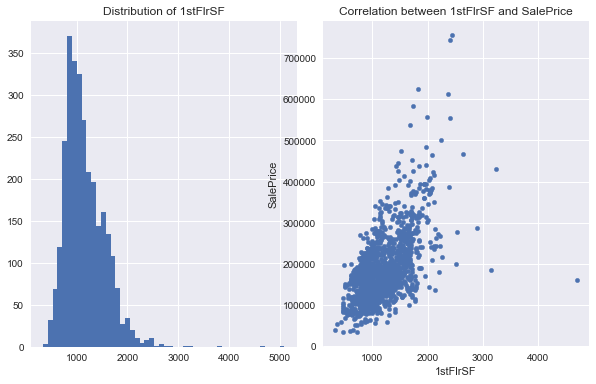

Feature FullBath is of type int64 with 0 missing values


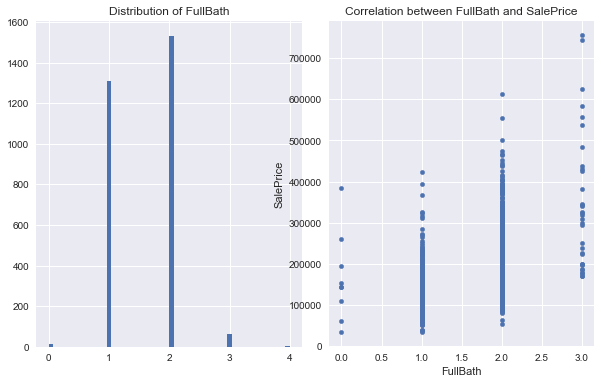

Feature TotRmsAbvGrd is of type int64 with 0 missing values


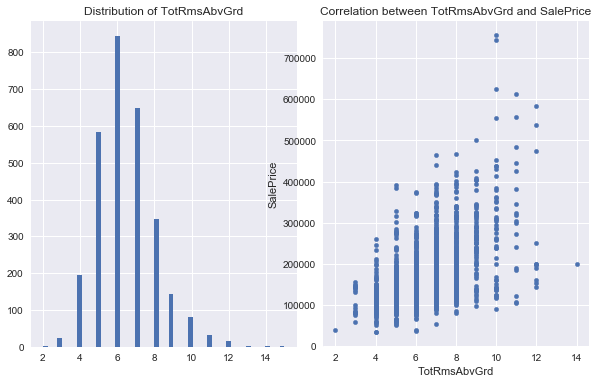

Feature YearBuilt is of type int64 with 0 missing values


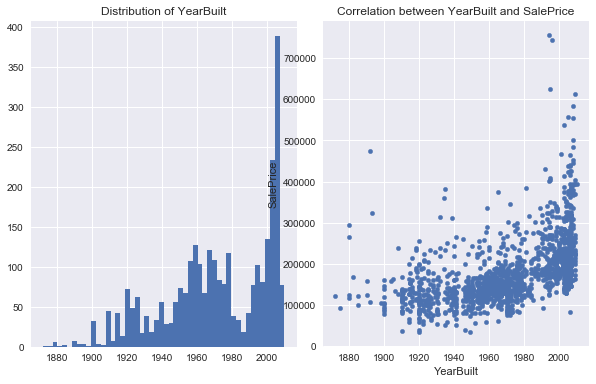

In [270]:
target="SalePrice"
for feature in top10_attributes:
    explore_variable(data, feature, target)